# Interface Boundary Conditions (DDM) for the dispersive part of the Serre Equation

* Definition and validation
* No advection
* Objective : application to the DDM coupling Serre and NSWE


## Procedure
* Resolution of the dispersive part of the Serre equations in a 2 domains DDM
* Reference solution : solution computed in the mono domain
* BCs for the dispersion : 
    * interface --> TBC
    * boundary --> doesn't matter

## Resolution functions

In [1]:
%%writefile serreTBC.py

import sys
sys.path.append('../')
sys.path.append('../nswe')

import numpy as np
import matplotlib.pyplot as plt
import serre
import cnoidal
import nswe_wbmuscl4 as wb4


nan = float("nan")

Overwriting serreTBC.py


In [2]:
%%writefile serreTBC.py -a

import convolution as cvl

def imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt,Y=[],eta=0.,hp1=[]):
    
    """
    Impose three boundary conditions for the dispersive part
    
    - Inputs :
        * M : matrix of the FD scheme
        * rhs : right-hand side of the FD scheme
        * BCs : array of dimensions 3x3 containing one TBC in each line, in the form
            [Position,Type,Value,Opt], where
                ::: Position (int) : indicates the point to be modified (0,1,...,-2,-1)
                ::: Type (str) : indicates the type of BC : "Dirichlet"/"Neumann"/"TBC"
                ::: Value (float) : value of the BC
                ::: Opt [int,float,array] : optional coefficients for the TBC; depends on the Type 
        * h,hx,hu : informations from the last computation
        * dt
        * hp1 : h from the next iteration
        
    - Outputs :
        * M
        * rhs
    """
    gr = 9.81
    
    ### verif number of TBCs
    #if BCs.shape[0] != 3 :
    #    sys.exit("Wrong number of BCs")
        
    ## impose BCs
    for i in range(BCs.shape[0]) :
        [pos,typ,val] = BCs[i,:3]
        pos = int(pos)
        val = float(val)
        if typ == "Dirichlet" :
            M[pos,:] = 0.
            M[pos,pos] = 1.
            rhs[pos] = -(val*hp1[pos]-hu[pos] - dt*gr*h[pos]*hx[pos])/dt
        elif typ == "Neumann" :
            M[pos,:] = 0.
            if pos == 0:
                M[0,0] = -h[1]
                M[0,1] = h[0]
                rhs[0] = h[0]*h[1]/dt*(u[1]-u[0] + dt*gr*(hx[1]-hx[0]) - val*dx)
            else:
                M[pos,pos] = h[pos-1]
                M[pos,pos-1] = -h[pos]
                rhs[pos] = h[pos]*h[pos-1]/dt*(u[pos]-u[pos-1] + dt*gr*(hx[pos]-hx[pos-1]) - val*dx)
        elif typ == "Robin" :
            alpha = float(BCs[i,3])
            beta = float(BCs[i,4])
            M[pos,:] = 0.
            if pos == 0 or pos == -2 :
                M[pos,pos] = dt*h[pos+1]*(alpha*dx - beta)
                M[pos,pos+1] = beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos+1]*(\
                                    alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                    beta*(u[pos+1] - u[pos] + dt*gr*(hx[pos+1]-hx[pos])) - dx*val)
            elif pos == 1 or pos == -1 :
                M[pos,pos] = dt*h[pos-1]*(alpha*dx + beta)
                M[pos,pos-1] = -beta*dt*h[pos]
                rhs[pos] = h[pos]*h[pos-1]*(\
                                            alpha*dx*(u[pos]+dt*gr*hx[pos]) + \
                                            beta*(u[pos] - u[pos-1] + dt*gr*(hx[pos]-hx[pos-1])) - dx*val)
        elif typ == "TBC" or typ == "TBC2" or typ == "TBC3":  ##alpha*uxx + beta*ux + gamma*u = val 

            if typ == "TBC" :
                alpha = float(BCs[i,3])
                beta = float(BCs[i,4])
                gamma = float(BCs[i,5])
            elif typ == "TBC2" : ##with time derivative
                if pos == 0 :
                    alpha = u[0]*dt
                    beta = 1. - dt*(u[1]-u[0])/dx
                    gamma = 0.
                    val = (u[1]-u[0])/dx
                elif pos == -1 :
                    alpha = u[-1]*dt
                    beta = 1. - dt*(u[-1]-u[-2])/dx
                    gamma = 0.
                    val = (u[-1]-u[-2])/dx
            elif typ == "TBC3" : ##with time derivative : ut + u + ux + uxx= 0
                if pos == 0 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[0]
                elif pos == -1 :
                    alpha = dt
                    beta = dt
                    gamma = 1. + dt
                    val = u[-1]
            M[pos,:] = 0.
            if pos == 0:
                c0 = alpha/(dx*dx) - beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) + beta/dx
                c2 = alpha/(dx*dx)
                M[0,0] = -dt/h[0]*c0
                M[0,1] = -dt/h[1]*c1
                M[0,2] = -dt/h[2]*c2
                rhs[0] =val - (u[0]+dt*gr*(hx[0]+eta))*c0 - (u[1]+dt*gr*(hx[1]+eta))*c1 - (u[2]+dt*gr*(hx[2]+eta))*c2
            elif pos == 1 :
                c0 = alpha/(dx*dx) - beta/dx
                c1 = -2.*alpha/(dx*dx) + beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[1,0] = -dt/h[0]*c0
                M[1,1] = -dt/h[1]*c1
                M[1,2] = -dt/h[2]*c2
                rhs[1] =val - (u[0]+dt*gr*(hx[0]+eta))*c0 - (u[1]+dt*gr*(hx[1]+eta))*c1 - (u[2]+dt*gr*(hx[2]+eta))*c2
            elif pos == -1 :
                c0 = alpha/(dx*dx) + beta/dx + gamma
                c1 = -2.*alpha/(dx*dx) - beta/dx
                c2 = alpha/(dx*dx)
                M[pos,pos] = -dt/h[pos]*c0
                M[pos,pos-1] = -dt/h[pos-1]*c1
                M[pos,pos-2] = -dt/h[pos-2]*c2
                rhs[pos] =val - (u[pos]+dt*gr*(hx[pos]+eta))*c0 - (u[pos-1]+dt*gr*(hx[pos-1]+eta))*c1 - \
                                (u[pos-2]+dt*gr*(hx[pos-2]+eta))*c2
            elif pos == -2 :
                c0 = alpha/(dx*dx) + beta/dx
                c1 = -2.*alpha/(dx*dx) - beta/dx + gamma
                c2 = alpha/(dx*dx)
                M[pos,pos+1] = -dt/h[pos+1]*c0
                M[pos,pos] = -dt/h[pos]*c1
                M[pos,pos-1] = -dt/h[pos-1]*c2
                rhs[pos] =val - (u[pos+1]+dt*gr*(hx[pos+1]+eta))*c0 - (u[pos]+dt*gr*(hx[pos]+eta))*c1 -\
                                (u[pos-1]+dt*gr*(hx[pos-1]+eta))*c2
                            
        elif typ == "DTBC_Y":
            
            M[pos,:] = 0.
            
            if pos == 0:
                # Left TBC 1 ==> unknown = U[0]
                M[0,0]      =  1.
                M[0,1]      = -   Y[4,0]
                M[0,2]      =     Y[6,0]
                # rhs[0] = Ct[4,1] - Ct[6,2]
                rhs[0] = val
            elif pos == 1:
                # Left TBC 2 ==> unknown = U[1]
                M[1,0]    =  1.
                M[1,2]    = -   Y[5,0]
                M[1,3]    =  2.*Y[8,0]
                M[1,4]    = -   Y[7,0]
                # rhs[1] = Ct[5,2] - 2*Ct[8,3] + Ct[7,4]
                rhs[1] = val
            elif pos == -1:
                ## Right TBC 1 ==> unkonwn = U[J]
                M[-1,-1]    =  1.
                M[-1,-2]    = -   Y[0,0]
                M[-1,-3]    =     Y[2,0]
                # rhs[-1] = Ct[0,-2] - Ct[2,-3]
                rhs[-1] = val
            elif pos == -2:
                ## Right TBC 2 ==> unknown = U[J-1]
                M[-2,-1]  =  1.
                M[-2,-2]  = -2.*Y[0,0]
                M[-2,-3]  =     Y[1,0]
                M[-2,-5]  = -   Y[3,0]
                # rhs[-2] = 2*Ct[0,-2] - Ct[1,-3] + Ct[3,-5]
                rhs[-2] = val
                    
        else :
            sys.exit("Wrong type of TBC!! Please use Dirichlet/Neumann/TBC")
        
    return M,rhs

Appending to serreTBC.py


In [3]:
%%writefile serreTBC.py -a

def EFDSolverFM4(h,u,dx,dt,order,BCs,it,periodic=False,ng=2,side="left",href=None,uref=None,Y=[],eta=0.,
                 hp1=[],domain=0,ind=0,zref=None):
    
    """
    Finite Difference Solver for the second step of the splitted Serre equations, using the discretization derived
    in the paper of Fabien Marche
    MODIFICATION : imposition of BCs
    
    - Parameters
        * h,u (1D array) : solution
        * dx,dt,t (integers) : space step, time step, time
        * BCfunction (function) : function that modifies the linear system to impose the BCs
        * BCparam (1D array) : argument for BCfunction; contains the BCs in the form
             BC=[u(left),ux(left),uxx(left),alpha1*u(left) + beta1*ux(right) + gamma1*uxx(right),
                u(right),ux(right),uxx(right),alpha2*u(right) + beta2*ux(right) + gamma2*uxx(right),
                alpha1,beta1,gamma1,alpha2,beta2,gamma2,Fleft,Fright] 
        * periodic (boolean) : indicates if the function is periodic
        * hp1 : h from the next iteration
        
    - Returns
        * u2 (1D array) : solution (velocity)
    """
    
    gr = 9.81

    hu = h*u
    
    if hp1 == []:
        hp1 = np.copy(h)
        
    ordre = 2
    
    ux = serre.get1d(u,dx,periodic,order=order)
    uxx = serre.get2d(u,dx,periodic,order=order)
    uux = u*ux
    uuxdx = serre.get1d(uux,dx,periodic,order=order)
    hx = serre.get1d(h,dx,periodic,order=order)
    hxx = serre.get2d(h,dx,periodic,order=order)
    h2x = serre.get1d(h*h,dx,periodic,order=order)
    hhx = h*hx
    
    if domain == 1:
        u = u[:ind]
        ux = ux[:ind]
        uxx = uxx[:ind]
        uux = uux[:ind]
        uuxdx = uuxdx[:ind]
        h = h[:ind]        
        hx = hx[:ind]
        hxx = hxx[:ind]
        h2x = h2x[:ind]
        hhx = hhx[:ind]
        hu = h*u
    elif domain == 2:
        u = u[ind:]
        ux = ux[ind:]
        uxx = uxx[ind:]
        uux = uux[ind:]
        uuxdx = uuxdx[ind:]
        h = h[ind:]        
        hx = hx[ind:]
        hxx = hxx[ind:]
        h2x = h2x[ind:]
        hhx = hhx[ind:]
        hu = h*u
    
    Q = 2.*h*hx*ux*ux + 4./3.*h*h*ux*uxx + eta*eta*h*u*ux + eta*eta*(hx+eta)*u*u
    rhs = gr*h*hx + h*Q + gr*h*eta      
     
    d0 = 1. + hx*hx/3. + h*hxx/3. + 5.*h*h/(6.*dx*dx) + eta*(hx+eta)
    dp1 = -2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dp1 = dp1[0:-1]
    dm1 = +2./3.*h*hx/(3.*dx) - 4./3.*h*h/(3.*dx*dx)
    dm1 = dm1[1:]
    dp2 = 1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dp2 = dp2[0:-2]
    dm2 = -1./3.*h*hx/(12.*dx) + 1./3.*h*h/(12.*dx*dx)
    dm2 = dm2[2:]
                
    M = np.diag(d0) + np.diag(dp1,1) + np.diag(dm1,-1) + np.diag(dp2,2) + np.diag(dm2,-2)
    
    M[0,:] = 0
    M[1,:] = 0
    M[-1,:] = 0
    M[-2,:] = 0

    ### Decenter it at the boundaries (but in general these lines are replaced by the BC)
    M[0,0] = h[0]*(1. - 3./4.*h2x[0]/dx - 2./3.*h[0]*h[0]/(dx*dx))
    M[0,1] = h[0]*(h2x[0]/dx + 5./3.*h[0]*h[0]/(dx*dx))
    M[0,2] = h[0]*(-1./4.*h2x[0]/dx - 4./3.*h[0]*h[0]/(dx*dx))
    M[0,3] = h[0]*(1./3.*h[0]*h[0]/(dx*dx))

    M[1,1] = h[1]*(1. - 3./4.*h2x[1]/dx - 2./3.*h[1]*h[1]/(dx*dx))
    M[1,2] = h[1]*(h2x[1]/dx + 5./3.*h[1]*h[1]/(dx*dx))
    M[1,3] = h[1]*(-1./4.*h2x[1]/dx - 4./3.*h[1]*h[1]/(dx*dx))
    M[1,4] = h[1]*(1./3.*h[1]*h[1]/(dx*dx))    
    
    M[-1,-1] = h[-1]*(1. + 3./4.*h2x[-1]/dx - 2./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-2] = h[-1]*(-h2x[-1]/dx + 5./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-3] = h[-1]*(1./4.*h2x[-1]/dx - 4./3.*h[-1]*h[-1]/(dx*dx))
    M[-1,-4] = h[-1]*(1./3.*h[-1]*h[-1]/(dx*dx))
      
    M[-2,-2] = h[-2]*(1. + 3./4.*h2x[-2]/dx - 2./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-3] = h[-2]*(-h2x[-2]/dx + 5./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-4] = h[-2]*(1./4.*h2x[-2]/dx - 4./3.*h[-2]*h[-2]/(dx*dx))
    M[-2,-5] = h[-2]*(1./3.*h[-2]*h[-2]/(dx*dx))
    ######

    np.set_printoptions(threshold=np.nan)
    # np.set_printoptions(suppress=True)
    
    if domain > 0:
    
        M,rhs = imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt,Y=Y,eta=eta,hp1=hp1)
        z = np.linalg.solve(M,rhs)
        
        Id = np.eye(len(u))
        Id0 = np.copy(Id)
        Id0[0,0] = 0.
        Id0[1,1] = 0.
        Id0[-2,-2] = 0.
        Id0[-1,-1] = 0.

        b = np.zeros_like(hu)
        for i in range(BCs.shape[0]) :
            [pos,typ,val] = BCs[i,:3]
            b[pos] = hp1[pos]*val
            
        hu2 = np.dot(Id0,hu + dt*(gr*h*(hx+eta)-z)) + b
    
    else:
        M,rhs = imposeBCDispersive(M,rhs,BCs,h,u,hx,hu,dx,dt,Y=Y,eta=eta,hp1=hp1)
        z = np.linalg.solve(M,rhs)
        hu2 = hu + dt*(gr*h*(hx+eta)-z)
    
    return hu2/hp1, z

Appending to serreTBC.py


In [4]:
%%writefile serreTBC.py -a

def solveDispersiveSerre(u,href,t0,tmax,dt,dx,BCconfig,uref=None,debug=False,idxlims=None, Y=[]):
    
    t = t0
    it = 0 ## index of timestep
    grav = 9.8
    
    ## store solutions of all timesteps
    uall = u
    tall = np.ones(1)*t0
    
    while abs(t-tmax) > 10**(-12):
            
        ## h(t) = referential solution
        h = href[:,it]
        hu = h*u

        FDorder = 4 
        
        if debug :
            BCconfig[0,2] = uref[idxlims[0],it+1]
            BCconfig[1,2] = uref[idxlims[1],it+1]
            BCconfig[2,2] = uref[idxlims[0]+1,it+1]
            BCconfig[3,2] = uref[idxlims[1]-1,it+1]
            # BCconfig[4,2] = uref[idxlims[0]+2,it+1]
            # BCconfig[5,2] = uref[idxlims[1]-2,it+1]
        u,z = EFDSolverFM4(h,u,dx,dt,FDorder,BCconfig,it,Y=Y, hp1=href[:,it+1])
        
        if it == 0:
            zall = z
        else:
            zall = np.column_stack((zall,z))
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))        
        
        t = t+dt
        it = it+1
        
    return uall,zall,tall

Appending to serreTBC.py


In [5]:
%%writefile serreTBC.py -a

def norm2(u, dx):
  """
  Return the l^2 norm of an numpy array.
  """

  return np.sqrt(dx*np.sum(u**2))


def solveDispersiveSerreDDM(u,href,t0,tmax,dt,dx,cond_int,cond_bound,uref=None,zref=None,debug=False,Y=[],uall=None):
    """
    If the DDM is overlapping : N1+N2 >= N+2, otherwise N1+N2 = N+1.

                   0 1 2                                                    N-2 N-1=J
    Monodomain   = [ - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ]
                   0 1 2             |         N1-2 N1-1=J_1
    Left Domain  = [ - - - - - - - - - - - - - - - ]
                                     | 1 2         |                       N2-2 N2-1=J_2
    Right Domain =                   [ - - - - - - - - - - - - - - - - - - - - ]
                                     |             |
    Index on the monodomain   :     N-N2          N1-1
    Index on the left domain  :     N-N2          N1-1
    Index on the right domain :      0          N1+N2-N-1

                                    O12            J21
    """
    
    ## time steps
    t = t0
    it = 0     
    
    ## parameters for the DDM
    n = len(u)
    j = n-1
    n1 = int((3./4.)*n)
    j1 = n1-1
    # minimal overlapping for our TBC : n = n1+n2-5
    n2 = n-n1+4
    # n2 = int((3./4.)*n)
    j2 = n2-1
    ## communication between domains
    # last node of the left domain in the right domain
    j21 = n1+n2-n-1
    # first node of the right domain in the left domain
    o12 = n-n2
    
    ## initialization
    u1 = u[:n1]
    u2 = u[n-n2:]
    
    ## store solutions of all timesteps
    uall = np.copy(u)
    u1all = np.copy(u1)
    u2all = np.copy(u2)
    tall = np.ones(1)*t0
    
    ## precision
    nitermax = 1000
    eps = 10**(-12)

    print "*** starting DDM resolution with {} at the interface".format(cond_int)
    print " * "
    print " *  precision = {:.3e}".format(eps)
    print " * "
    
    while abs(t-tmax) > 10**(-12):
               
        ## h(t) = referential solution
        # we don't update it as we are working only on the dispersive part
        u1 = uref[:n1,it]
        h1 = href[:n1,it]
        h1u1 = h1*u1
        u2 = uref[n-n2:,it]
        h2 = href[n-n2:,it]
        h2u2 = h2*u2
        ## order of the dispersive solver
        FDorder = 4 
        
        ## starting the Schwarz algorithm
        cvg = False
        niter = 0
        
        while niter < nitermax and cvg == False:
            
            ## \Omega_1 : left --> BC, right --> IBC
            if debug:
                val11 = uref[j1,it+1]
                val12 = uref[j1-1,it+1]
                bc11 = uref[0,it+1]
                bc12 = uref[1,it+1]
            elif cond_int == "Dirichlet":
                val11 = u2[j21]
                val12 = u2[j21-1]
                bc11 = 0.
                bc12 = 0.
            else:
                val11 = 0.
                val12 = 0.
            BCconfig1 = np.array([[0,cond_bound,bc11,1.,0.,1.],
                                 [-1,cond_int,val11,1.,0.,1.],
                                 [1,cond_bound,bc12,1.,0.,1.],
                                 [-2,cond_int,val12,1.,0.,1.]], dtype=object)
            
            ## solving in the left domain
            u1_save = np.copy(u1)
            u1,z1 = EFDSolverFM4(href[:,it],uref[:,it],dx,dt,FDorder,BCconfig1,it,
                                 Y=Y,hp1=href[:n1,it+1],domain=1,ind=n1,zref=zref[:n1,:])
            assert(len(u1) == n1)
            
            ## \Omega_2 : left --> IBC, right --> BC
            if debug:
                val21 = uref[o12,it+1]
                val22 = uref[o12+1,it+1]
                bc21 = uref[-1,it+1]
                bc22 = uref[-2,it+1]
            elif cond_int == "Dirichlet":
                val21 = u1_save[o12]
                val22 = u1_save[o12+1]
                bc21 = 0.
                bc22 = 0.
            else:
                val21 = 0.
                val22 = 0.
            BCconfig2 = np.array([[0,cond_int,val21,1.,0.,1.],
                                 [-1,cond_bound,bc21,1.,0.,1.],
                                 [1,cond_int,val22,1.,0.,1.],
                                 [-2,cond_bound,bc22,1.,0.,1.]], dtype=object)      
            
            ## solving in the right domain
            u2_save = np.copy(u2)
            u2,z2 = EFDSolverFM4(href[:,it],uref[:,it],dx,dt,FDorder,BCconfig2,it,
                                 Y=Y,hp1=href[o12:,it+1],domain=2,ind=o12,zref=zref[o12:,:])
            assert(len(u2) == n2)
            
            ## test convergence with reference to uref
            err_norm_ref = np.sqrt(norm2(u1-uref[:n1,it+1], dx)**2 + norm2(u2-uref[o12:,it+1], dx)**2)
            err_norm_cvg = np.sqrt(norm2(u1-u1_save, dx)**2 + norm2(u2-u2_save, dx)**2)
            err_norm = err_norm_ref
            if err_norm < eps:
                print " *  t = {:.2f} --> DDM cvg reached in {:4d} iterations, error = {:.3e}".format(t+dt,
                                                                                                      niter+1,
                                                                                                      err_norm)
                print " *  left domain interface  : {:.3e}".format(np.sqrt((u1[j1]-uref[j1,it+1])**2 +
                                                                           (u1[j1-1]-uref[j1-1,it+1])**2))
                print " *  right domain interface : {:.3e}".format(np.sqrt((u2[0]-uref[o12,it+1])**2 +
                                                                           (u2[1]-uref[o12+1,it+1])**2))
                print " *  z1-zref : {:.3e}".format(norm2(z1-zref[:n1,it],dx))
                print " *  left domain interface  : {:.3e}".format(np.sqrt((z1[j1]-zref[j1,it])**2 +
                                                                           (z1[j1-1]-zref[j1-1,it])**2))
                print " *  z2-zref : {:.3e}".format(norm2(z2-zref[o12:,it],dx))
                print " *  right domain interface : {:.3e}".format(np.sqrt((z2[0]-zref[o12,it])**2 +
                                                                           (z2[1]-zref[o12+1,it])**2))
                print " * "
                cvg = True
                u[:o12] = u1[:o12]
                u[o12:n1] = .5*(u1[o12:] + u2[:j21+1])
                u[n1:] = u2[j21+1:]
            
            niter += 1
            if niter == nitermax:
                # print abs(u1 - uref[:n1,it+1])
                # print abs(u2 - uref[o12:,it+1])
                print " *  t = {:.2f} --> DDM cvg not reached after {:4d} iterations, error = {:.3e}".format(t+dt,
                                                                                                             niter,
                                                                                                             err_norm)
                print " *  left domain interface  : {:.3e}".format(np.sqrt((u1[j1]-uref[j1,it+1])**2 + 
                                                                          (u1[j1-1]-uref[j1-1,it+1])**2))
                print " *  right domain interface : {:.3e}".format(np.sqrt((u2[0]-uref[o12,it+1])**2 + 
                                                                          (u2[1]-uref[o12+1,it+1])**2))
                print " *  z1-zref : {:.3e}".format(norm2(z1-zref[:n1,it],dx))
                print " *  left domain interface  : {:.3e}".format(np.sqrt((z1[j1]-zref[j1,it])**2 +
                                                                           (z1[j1-1]-zref[j1-1,it])**2))
                print " *  z2-zref : {:.3e}".format(norm2(z2-zref[o12:,it],dx))
                print " *  right domain interface : {:.3e}".format(np.sqrt((z2[0]-zref[o12,it])**2 +
                                                                           (z2[1]-zref[o12+1,it])**2))
                print " * "
                u[:o12] = u1[:o12]
                u[o12:n1] = .5*(u1[o12:] + u2[:j21+1])
                u[n1:] = u2[j21+1:]
            
        ## stacking after convergence
        if it == 0:
            z1all = z1
            z2all = z2
        else:
            z1all = np.column_stack((z1all,z1))
            z2all = np.column_stack((z2all,z2))
        u1all = np.column_stack((u1all,u1))
        u2all = np.column_stack((u2all,u2))
        uall = np.column_stack((uall,u))
        tall = np.hstack((tall,t*np.ones(1)))
        
        
        t  += dt
        it += 1
        
    print "*** DDM over"
        
    return uall,u1all,u2all,z1all,z2all,tall

Appending to serreTBC.py


In [6]:
%%writefile serreTBC.py -a

def computeErrorTBC(u,uref,idxlims,dx,dt):
    lim1 = idxlims[0]
    lim2 = idxlims[1]
    uwind = uref[lim1:lim2+1,:]
    errDom = np.linalg.norm(u-uwind)*np.sqrt(dx*dt)
    errInt1 = np.linalg.norm(u[0,:]-uwind[0,:])*np.sqrt(dt)
    errInt2 = np.linalg.norm(u[-1,:]-uwind[-1,:])*np.sqrt(dt)
    
    return errDom,errInt1,errInt2
    

Appending to serreTBC.py


## Parameters and initialization

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import serre
import cnoidal
import nswe_wbmuscl4 as wb4
import sys
import serreTBC
import generalFunctions as gF

reload(serre)
reload(serreTBC)
%matplotlib inline

In [8]:
a0 = 1.
a1 = .1
k = 0.
g = 9.81
t0 = 0.
tmax = 10.
dt = 0.05

lam, h0 = cnoidal.WaveLengthDepth(k,a0,a1)

L = 3.*lam
xmin = -L
xmax = L
nx = 100
x,dx = serre.discretizeSpace(xmin,xmax,nx)
dx = np.diff(x)[0]

In [9]:
# Y coefficients for the DTBC of the linearized Serre equations

import Zt_tools as Z
print h0
# ps = Z.Parameters(1., dx, nx, xmin, xmax, dt)
# Nt = 100
# Nf = 10**4
# Y = Z.compute_Y(ps, Nf)
# Z.plot_Y(Y, Nf, log_scale = False, export = False)
K = Z.compute_K(dx, 1)

1.1
*** Starting computations of Ks
 *  roots of P : [0.05357164860823028, 0.33877688678801043, 2.951795234560233, 18.666589996380434]
 *  kernels :
[[3.92348535e-01]
 [1.53937373e-01]
 [1.81488363e-02]
 [3.29380260e-04]
 [3.92348535e-01]
 [1.53937373e-01]
 [1.81488363e-02]
 [3.29380260e-04]
 [7.12066936e-03]]
*** done


## Monodomain solution

In [10]:
t = t0
tallaux = np.arange(t0,tmax+dt,dt)
hallref = np.zeros((x.size,tallaux.size))
href,uref = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)
h,u = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)

## construct a solution for h
for j in range(tallaux.size):
    t = tallaux[j]
    hallref[:,j],trash = cnoidal.analyticalSolutionSolitary(x,t,a0,a1)
    hallref[:,j] = hallref[:,j] + np.flipud(hallref[:,j])

## solve referential solution
cond_bound = "Dirichlet"
BCconfigRef = np.array([[0,cond_bound,0.,1.,0.],
                     [-1,cond_bound,0.,1.,0.],
                     [1,cond_bound,0.,1.,0.],
                     [-2,cond_bound,0.,1.,0.]], dtype=object)
uallref,zallref,tallref = serreTBC.solveDispersiveSerre(uref,hallref,t0,tmax,dt,dx,BCconfigRef)

## DDM

In [11]:
reload(serreTBC)
## Debugging (Dirichlet condition using the values on the interface
cond_int = "Dirichlet"

uall,u1all,u2all,z1all,z2all,tall = serreTBC.solveDispersiveSerreDDM(u,hallref,t0,tmax,dt,dx,cond_int,cond_bound,
                                                            uref=uallref,zref=zallref,debug=False,Y=K)

umin = np.amin(uallref)
umax = np.amax(uallref)
hmin = np.amin(hallref)
hmax = np.amax(hallref)

*** starting DDM resolution with Dirichlet at the interface
 * 
 *  precision = 1.000e-12
 * 
 *  t = 0.05 --> DDM cvg reached in   32 iterations, error = 6.508e-13
 *  left domain interface  : 5.223e-13
 *  right domain interface : 3.745e-13
 *  z1-zref : 2.115e-11
 *  left domain interface  : 2.089e-11
 *  z2-zref : 1.517e-11
 *  right domain interface : 1.498e-11
 * 
 *  t = 0.10 --> DDM cvg reached in   32 iterations, error = 6.633e-13
 *  left domain interface  : 5.323e-13
 *  right domain interface : 3.818e-13
 *  z1-zref : 2.156e-11
 *  left domain interface  : 2.129e-11
 *  z2-zref : 1.547e-11
 *  right domain interface : 1.527e-11
 * 
 *  t = 0.15 --> DDM cvg reached in   32 iterations, error = 6.804e-13
 *  left domain interface  : 5.460e-13
 *  right domain interface : 3.918e-13
 *  z1-zref : 2.212e-11
 *  left domain interface  : 2.184e-11
 *  z2-zref : 1.587e-11
 *  right domain interface : 1.567e-11
 * 
 *  t = 0.20 --> DDM cvg reached in   32 iterations, error = 7.023e-1

 *  t = 1.55 --> DDM cvg reached in   35 iterations, error = 8.184e-13
 *  left domain interface  : 4.818e-13
 *  right domain interface : 6.488e-13
 *  z1-zref : 1.952e-11
 *  left domain interface  : 1.928e-11
 *  z2-zref : 2.629e-11
 *  right domain interface : 2.597e-11
 * 
 *  t = 1.60 --> DDM cvg reached in   35 iterations, error = 8.813e-13
 *  left domain interface  : 5.196e-13
 *  right domain interface : 6.981e-13
 *  z1-zref : 2.106e-11
 *  left domain interface  : 2.079e-11
 *  z2-zref : 2.829e-11
 *  right domain interface : 2.794e-11
 * 
 *  t = 1.65 --> DDM cvg reached in   35 iterations, error = 9.486e-13
 *  left domain interface  : 5.603e-13
 *  right domain interface : 7.507e-13
 *  z1-zref : 2.270e-11
 *  left domain interface  : 2.242e-11
 *  z2-zref : 3.043e-11
 *  right domain interface : 3.005e-11
 * 
 *  t = 1.70 --> DDM cvg reached in   36 iterations, error = 5.845e-13
 *  left domain interface  : 4.622e-13
 *  right domain interface : 3.457e-13
 *  z1-zref : 

 *  t = 3.15 --> DDM cvg reached in   38 iterations, error = 7.956e-13
 *  left domain interface  : 5.413e-13
 *  right domain interface : 5.687e-13
 *  z1-zref : 2.204e-11
 *  left domain interface  : 2.175e-11
 *  z2-zref : 2.322e-11
 *  right domain interface : 2.292e-11
 * 
 *  t = 3.20 --> DDM cvg reached in   38 iterations, error = 7.846e-13
 *  left domain interface  : 5.201e-13
 *  right domain interface : 5.734e-13
 *  z1-zref : 2.119e-11
 *  left domain interface  : 2.091e-11
 *  z2-zref : 2.343e-11
 *  right domain interface : 2.312e-11
 * 
 *  t = 3.25 --> DDM cvg reached in   38 iterations, error = 7.644e-13
 *  left domain interface  : 4.900e-13
 *  right domain interface : 5.733e-13
 *  z1-zref : 1.997e-11
 *  left domain interface  : 1.970e-11
 *  z2-zref : 2.344e-11
 *  right domain interface : 2.313e-11
 * 
 *  t = 3.30 --> DDM cvg reached in   38 iterations, error = 7.338e-13
 *  left domain interface  : 4.494e-13
 *  right domain interface : 5.674e-13
 *  z1-zref : 

 *  t = 4.75 --> DDM cvg reached in   43 iterations, error = 7.569e-13
 *  left domain interface  : 5.568e-13
 *  right domain interface : 4.905e-13
 *  z1-zref : 2.363e-11
 *  left domain interface  : 2.313e-11
 *  z2-zref : 2.093e-11
 *  right domain interface : 2.055e-11
 * 
 *  t = 4.80 --> DDM cvg reached in   43 iterations, error = 7.557e-13
 *  left domain interface  : 5.745e-13
 *  right domain interface : 4.674e-13
 *  z1-zref : 2.442e-11
 *  left domain interface  : 2.390e-11
 *  z2-zref : 1.997e-11
 *  right domain interface : 1.959e-11
 * 
 *  t = 4.85 --> DDM cvg reached in   43 iterations, error = 7.392e-13
 *  left domain interface  : 5.819e-13
 *  right domain interface : 4.313e-13
 *  z1-zref : 2.477e-11
 *  left domain interface  : 2.425e-11
 *  z2-zref : 1.844e-11
 *  right domain interface : 1.809e-11
 * 
 *  t = 4.90 --> DDM cvg reached in   43 iterations, error = 7.064e-13
 *  left domain interface  : 5.773e-13
 *  right domain interface : 3.817e-13
 *  z1-zref : 

 *  t = 6.35 --> DDM cvg reached in   41 iterations, error = 7.193e-13
 *  left domain interface  : 6.160e-13
 *  right domain interface : 3.473e-13
 *  z1-zref : 2.567e-11
 *  left domain interface  : 2.528e-11
 *  z2-zref : 1.438e-11
 *  right domain interface : 1.413e-11
 * 
 *  t = 6.40 --> DDM cvg reached in   41 iterations, error = 6.081e-13
 *  left domain interface  : 5.299e-13
 *  right domain interface : 2.773e-13
 *  z1-zref : 2.204e-11
 *  left domain interface  : 2.171e-11
 *  z2-zref : 1.146e-11
 *  right domain interface : 1.127e-11
 * 
 *  t = 6.45 --> DDM cvg reached in   40 iterations, error = 8.779e-13
 *  left domain interface  : 3.697e-13
 *  right domain interface : 7.821e-13
 *  z1-zref : 1.535e-11
 *  left domain interface  : 1.513e-11
 *  z2-zref : 3.228e-11
 *  right domain interface : 3.174e-11
 * 
 *  t = 6.50 --> DDM cvg reached in   40 iterations, error = 7.200e-13
 *  left domain interface  : 2.758e-13
 *  right domain interface : 6.540e-13
 *  z1-zref : 

 *  t = 7.90 --> DDM cvg reached in   38 iterations, error = 5.812e-13
 *  left domain interface  : 3.649e-13
 *  right domain interface : 4.429e-13
 *  z1-zref : 1.482e-11
 *  left domain interface  : 1.463e-11
 *  z2-zref : 1.797e-11
 *  right domain interface : 1.774e-11
 * 
 *  t = 7.95 --> DDM cvg reached in   37 iterations, error = 9.638e-13
 *  left domain interface  : 7.368e-13
 *  right domain interface : 6.022e-13
 *  z1-zref : 2.992e-11
 *  left domain interface  : 2.954e-11
 *  z2-zref : 2.443e-11
 *  right domain interface : 2.412e-11
 * 
 *  t = 8.00 --> DDM cvg reached in   37 iterations, error = 9.141e-13
 *  left domain interface  : 7.013e-13
 *  right domain interface : 5.681e-13
 *  z1-zref : 2.847e-11
 *  left domain interface  : 2.811e-11
 *  z2-zref : 2.304e-11
 *  right domain interface : 2.275e-11
 * 
 *  t = 8.05 --> DDM cvg reached in   37 iterations, error = 8.652e-13
 *  left domain interface  : 6.660e-13
 *  right domain interface : 5.350e-13
 *  z1-zref : 

 *  t = 9.50 --> DDM cvg reached in   34 iterations, error = 5.767e-13
 *  left domain interface  : 3.350e-13
 *  right domain interface : 4.606e-13
 *  z1-zref : 1.357e-11
 *  left domain interface  : 1.340e-11
 *  z2-zref : 1.866e-11
 *  right domain interface : 1.842e-11
 * 
 *  t = 9.55 --> DDM cvg reached in   33 iterations, error = 9.292e-13
 *  left domain interface  : 7.424e-13
 *  right domain interface : 5.394e-13
 *  z1-zref : 3.007e-11
 *  left domain interface  : 2.970e-11
 *  z2-zref : 2.185e-11
 *  right domain interface : 2.158e-11
 * 
 *  t = 9.60 --> DDM cvg reached in   33 iterations, error = 8.572e-13
 *  left domain interface  : 6.851e-13
 *  right domain interface : 4.972e-13
 *  z1-zref : 2.775e-11
 *  left domain interface  : 2.741e-11
 *  z2-zref : 2.014e-11
 *  right domain interface : 1.989e-11
 * 
 *  t = 9.65 --> DDM cvg reached in   33 iterations, error = 7.905e-13
 *  left domain interface  : 6.321e-13
 *  right domain interface : 4.582e-13
 *  z1-zref : 

*** Plotting animation ...



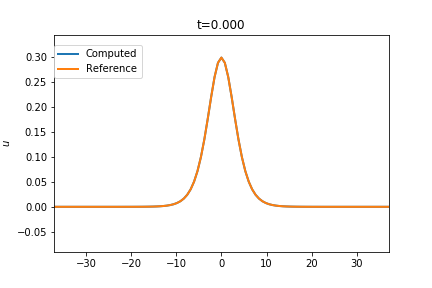
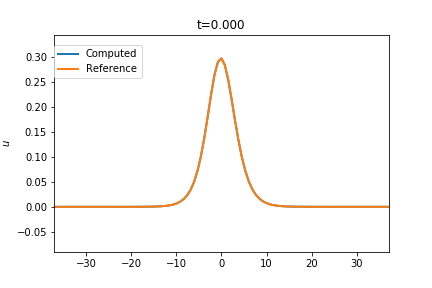
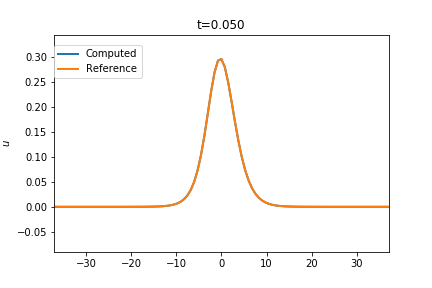
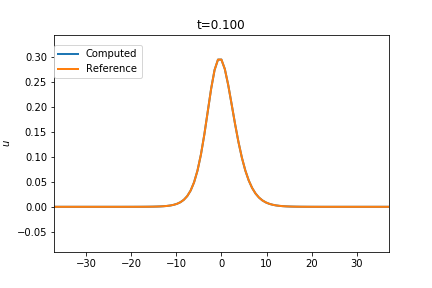
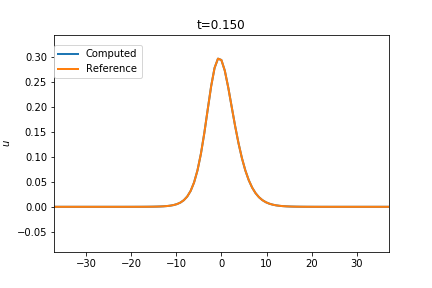
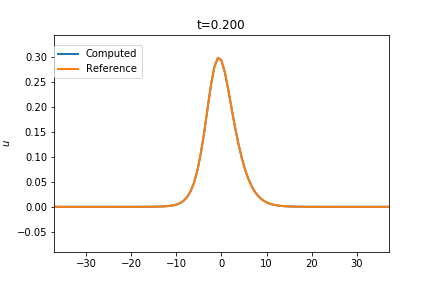
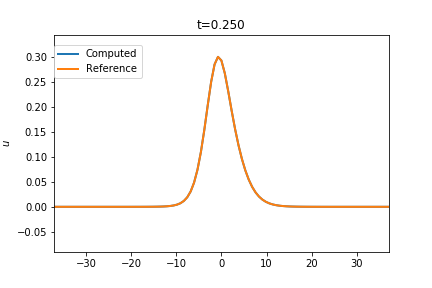
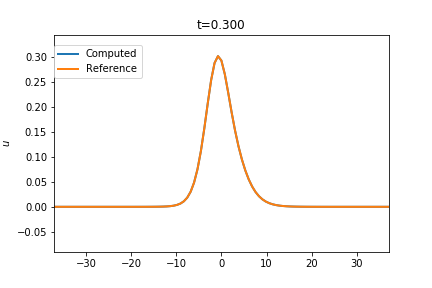
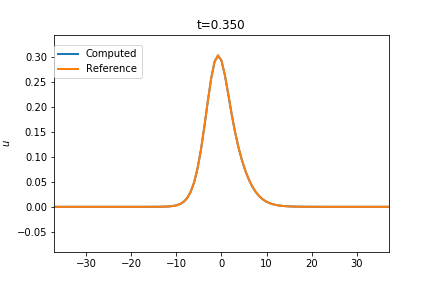
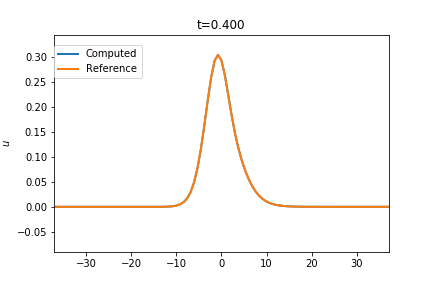
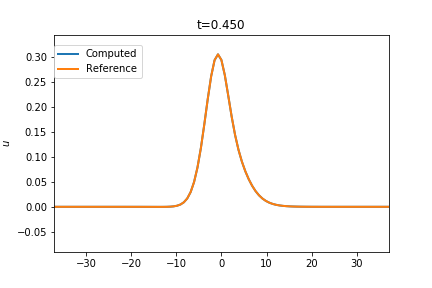
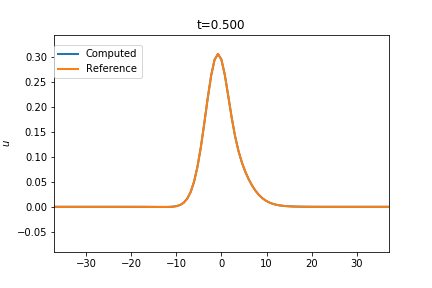
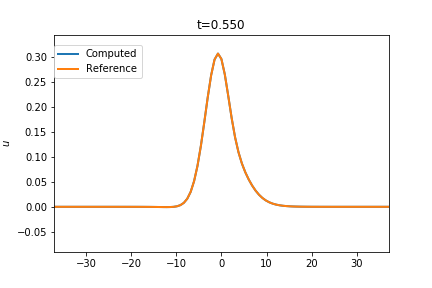
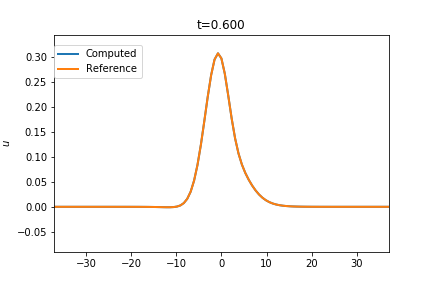
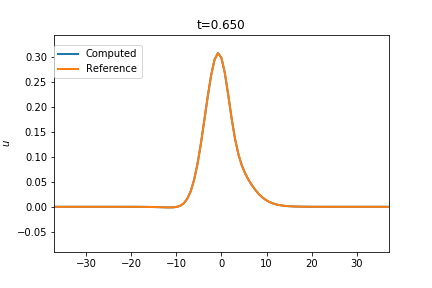
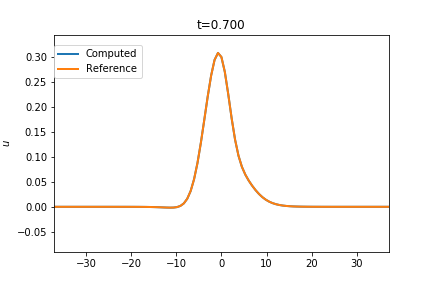
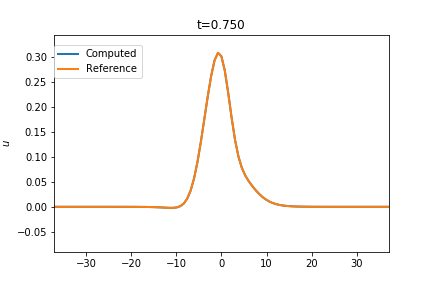
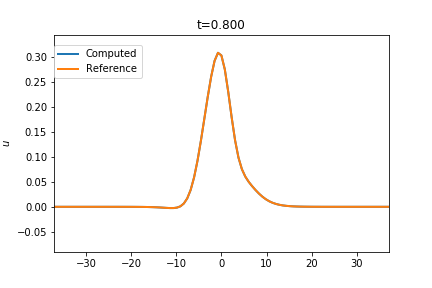
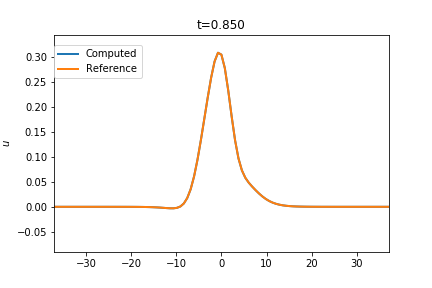
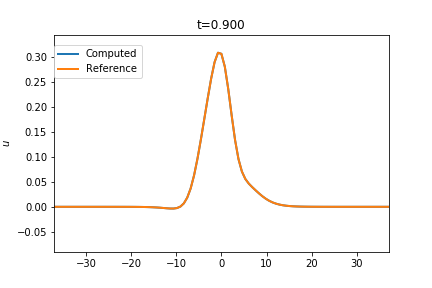
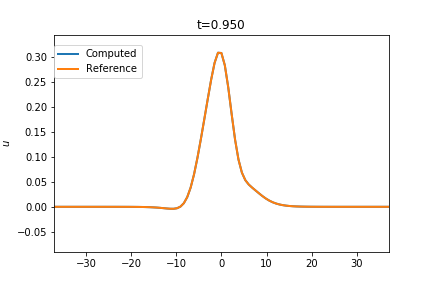
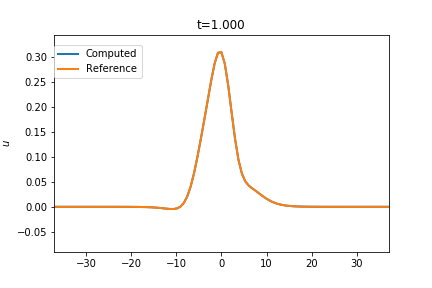
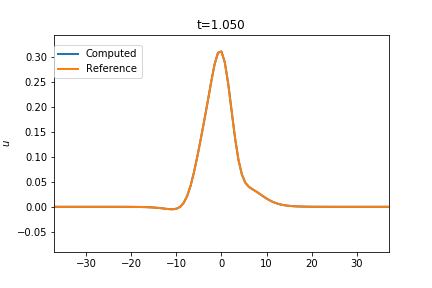
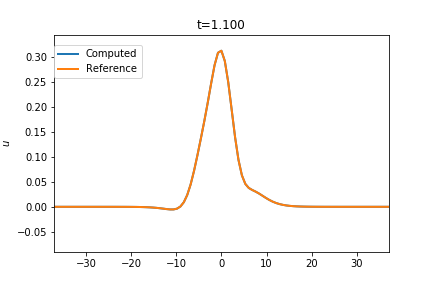
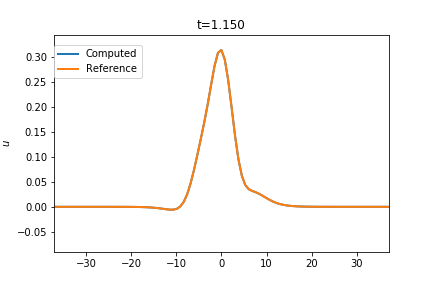
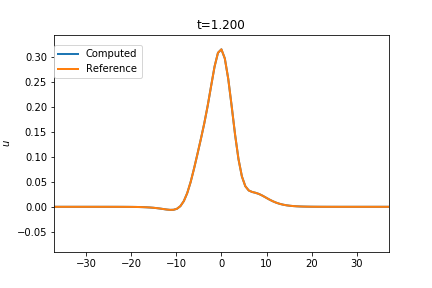
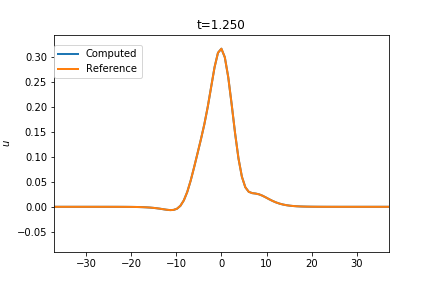
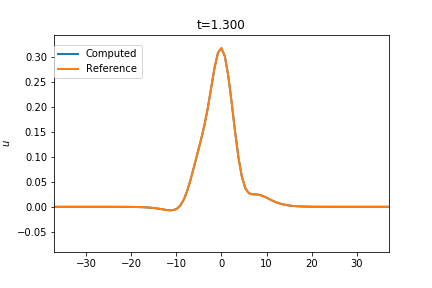
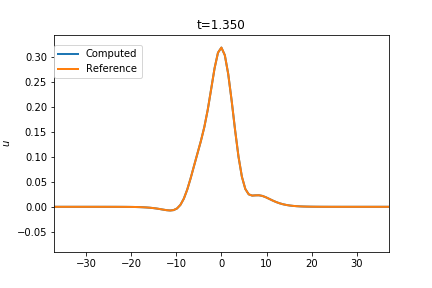
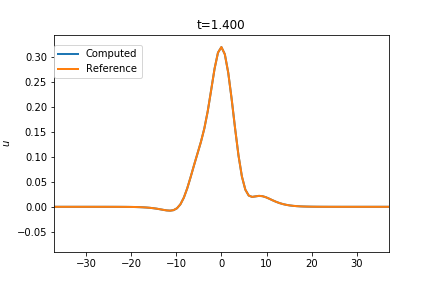
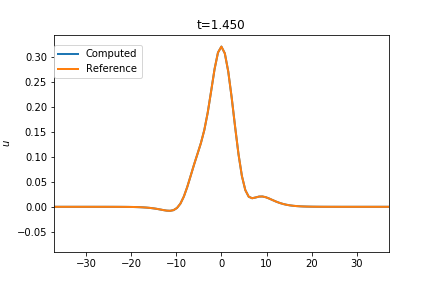
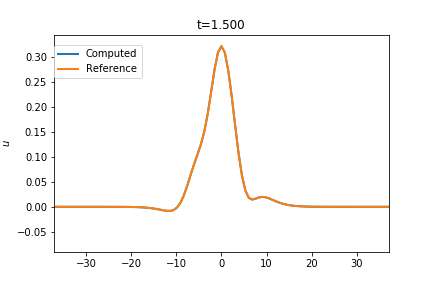
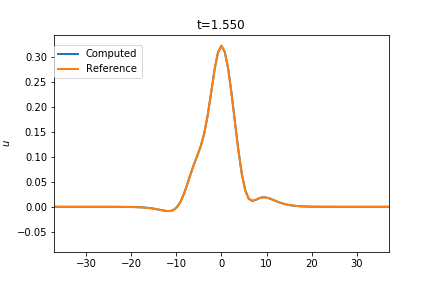
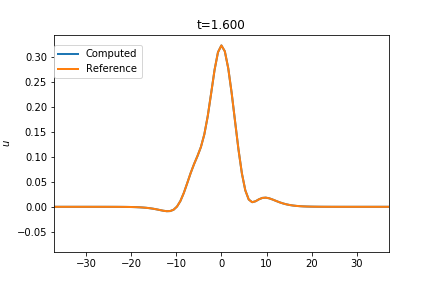
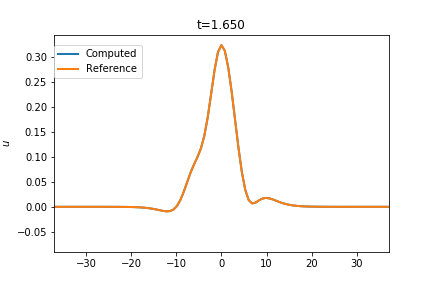
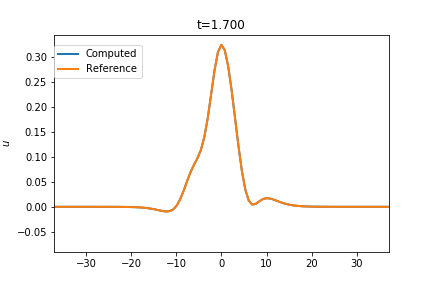
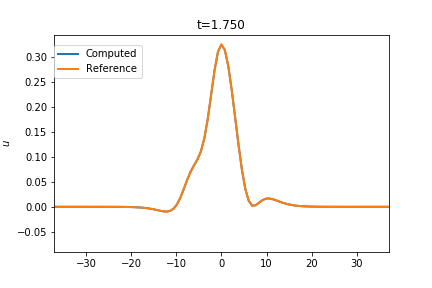
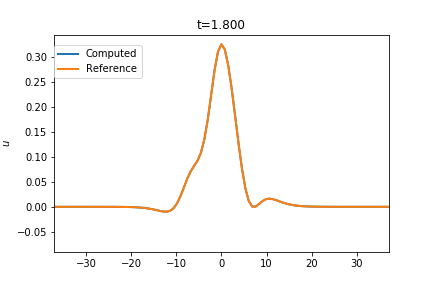
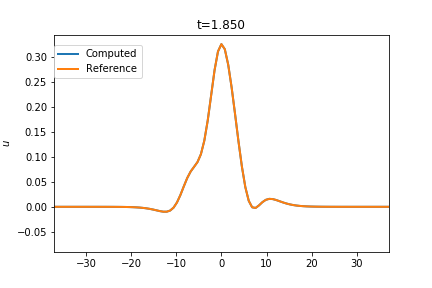
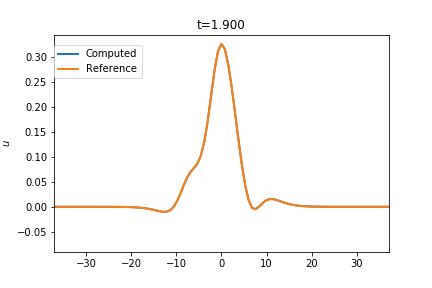
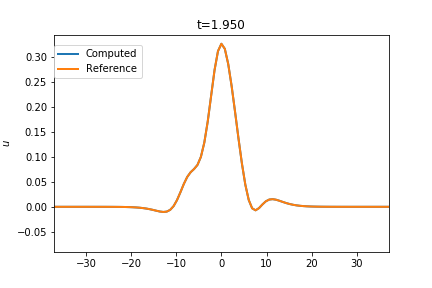
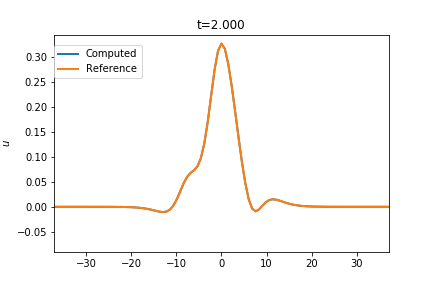
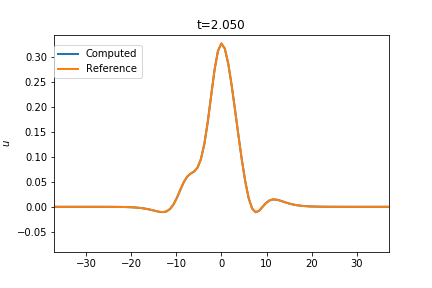
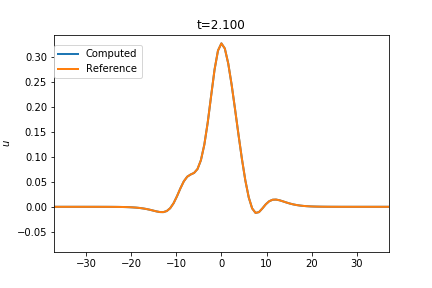
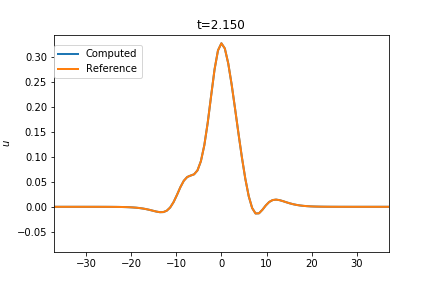
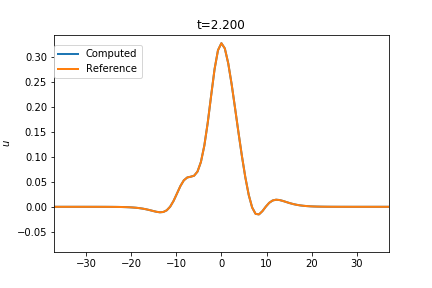
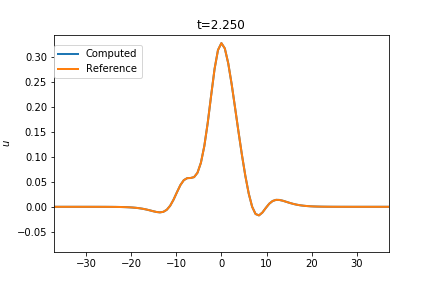
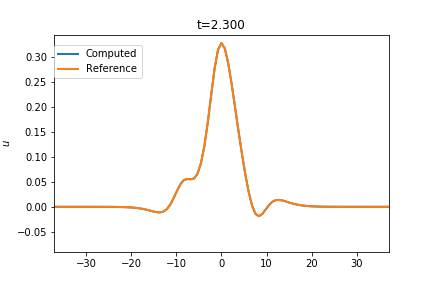
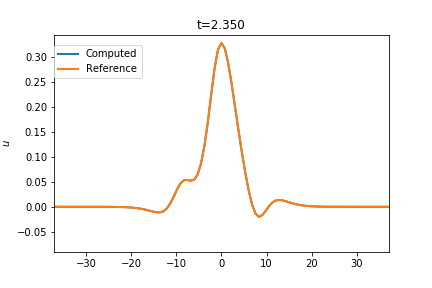
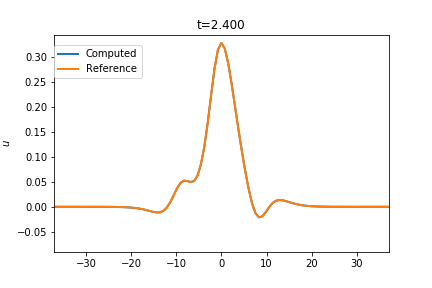
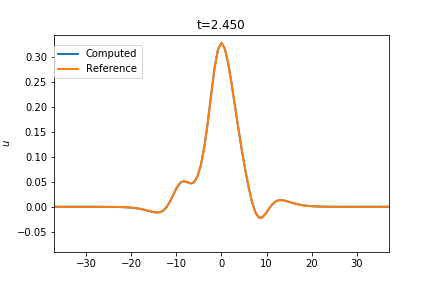
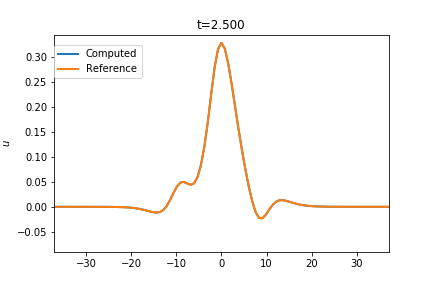
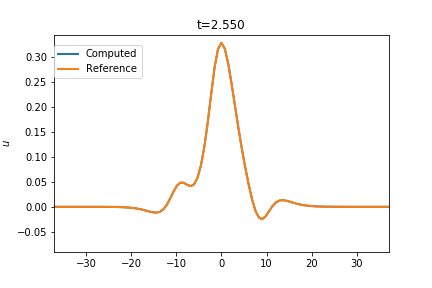
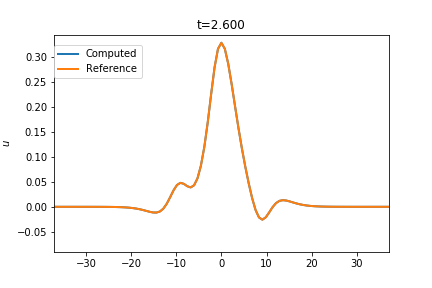
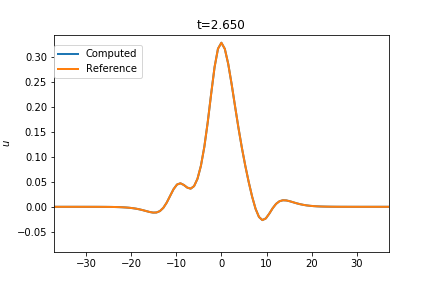
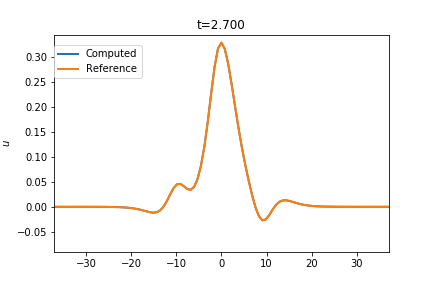
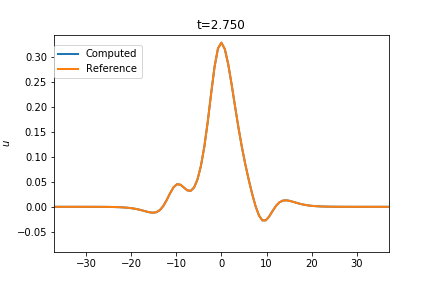
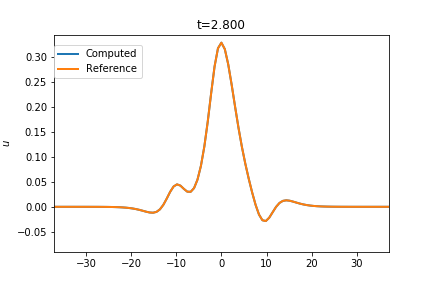
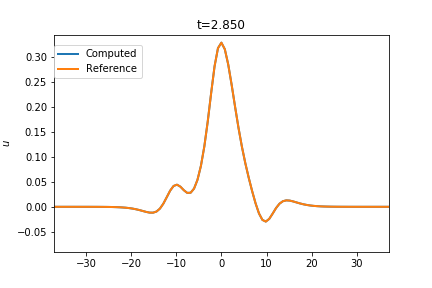
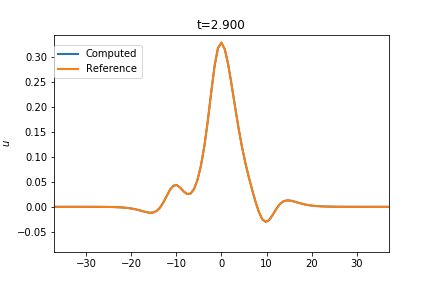
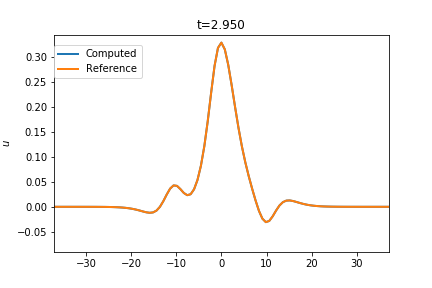
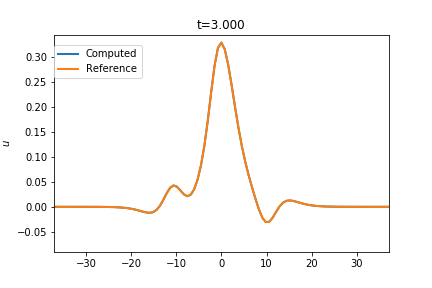
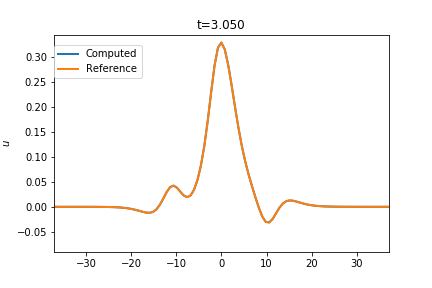
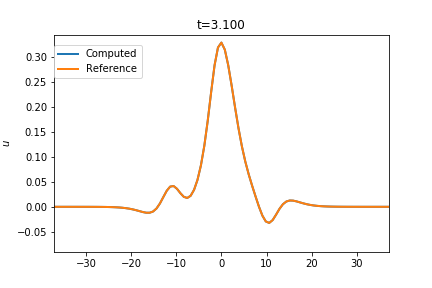
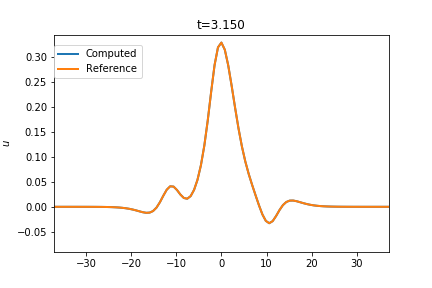
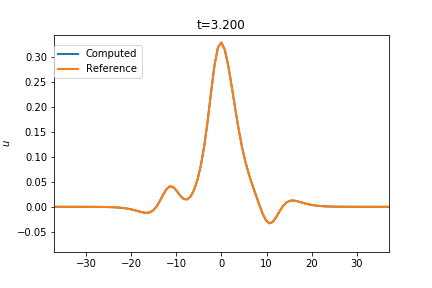
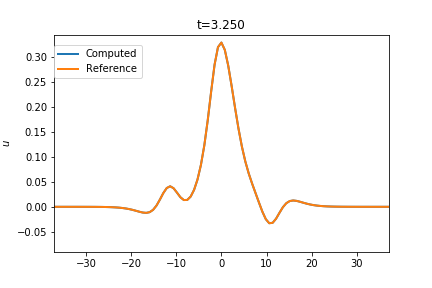
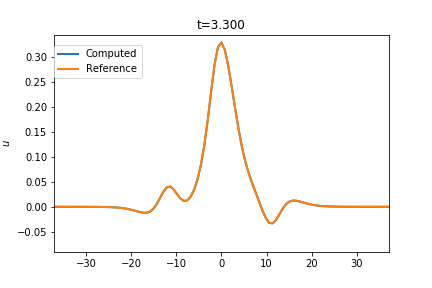
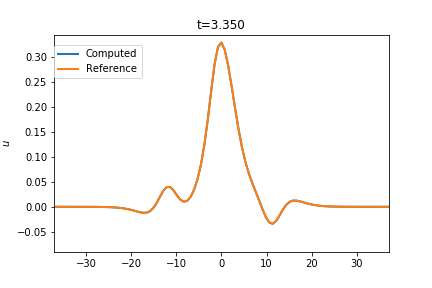
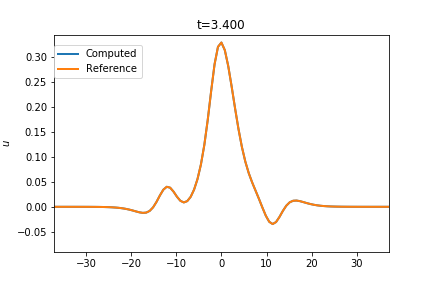
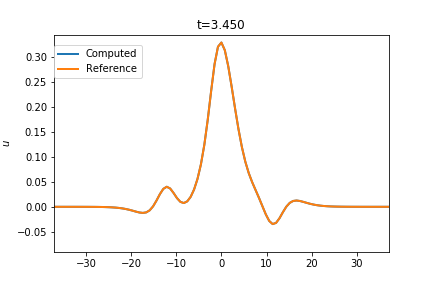
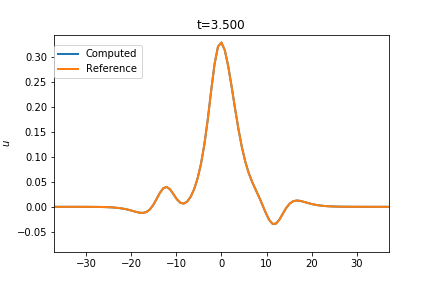
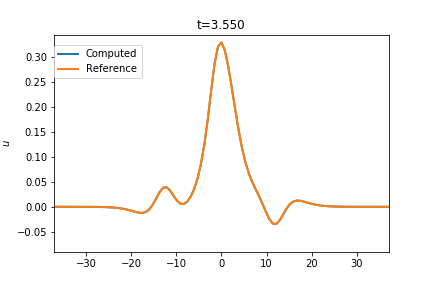
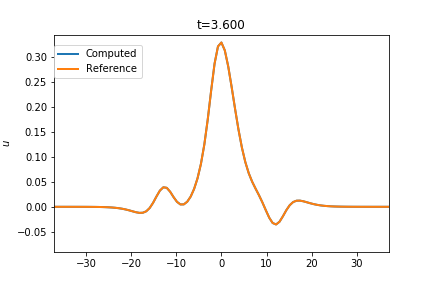
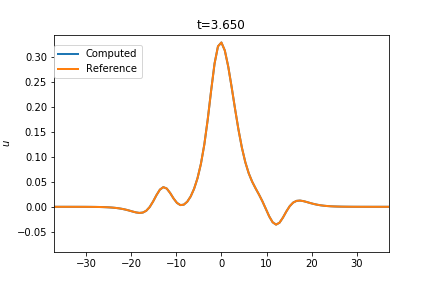
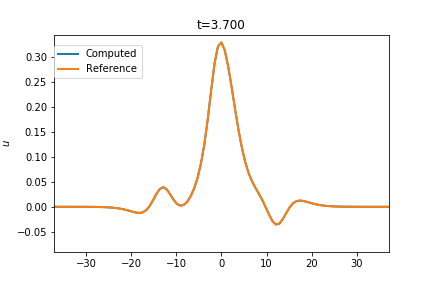
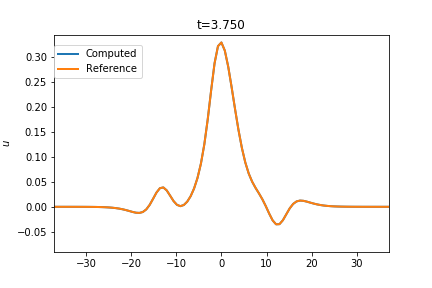
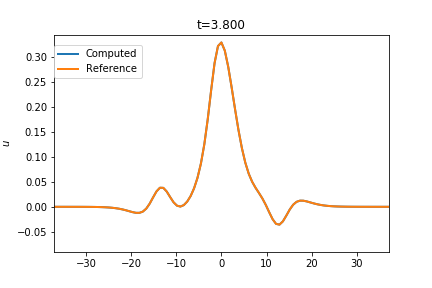
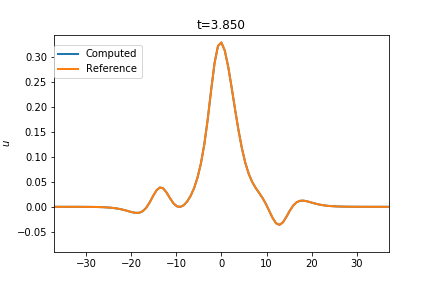
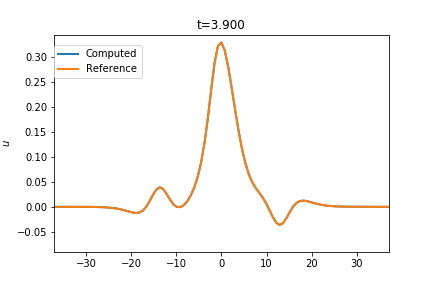
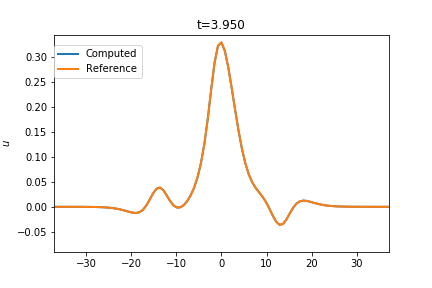
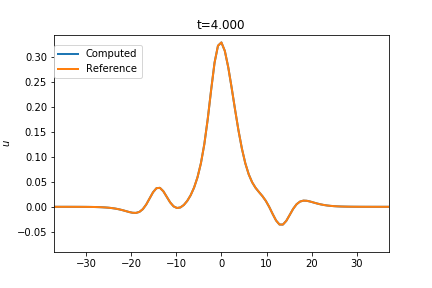
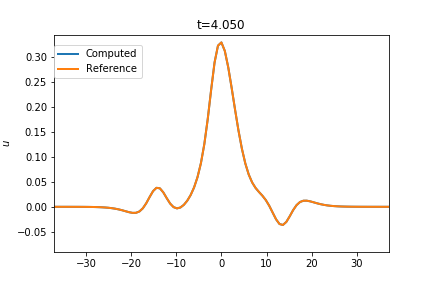
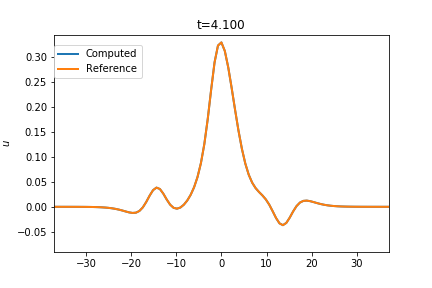
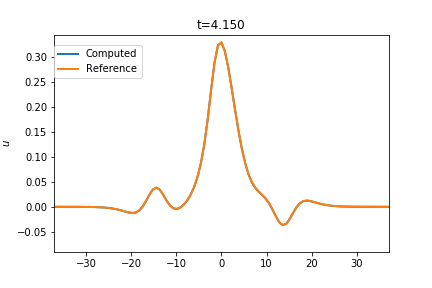
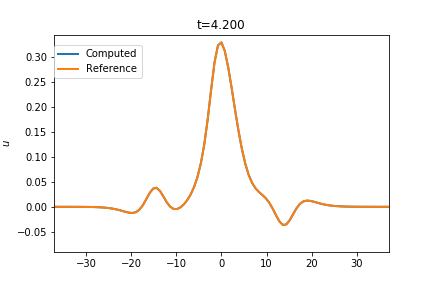
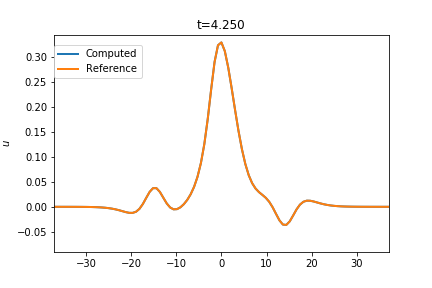
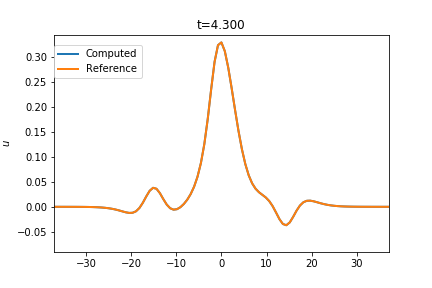
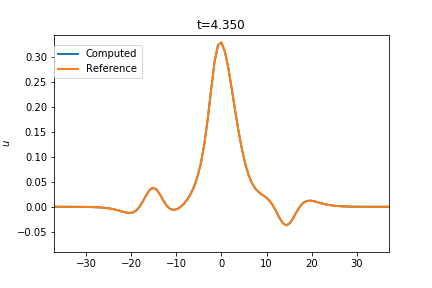
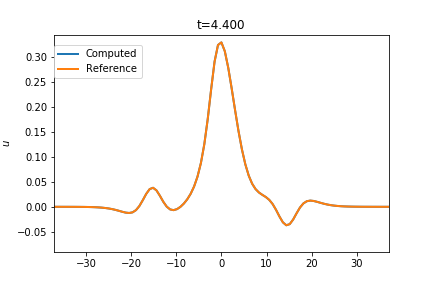
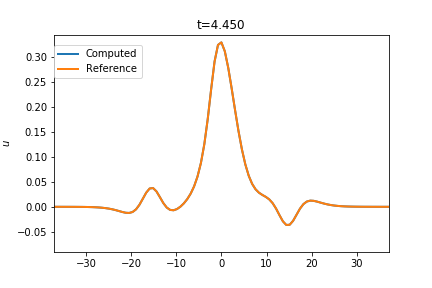
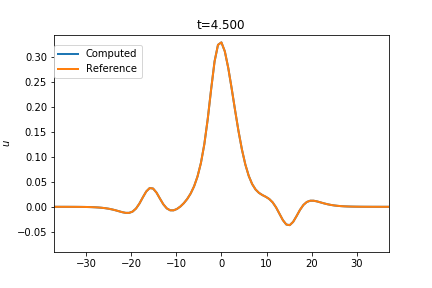
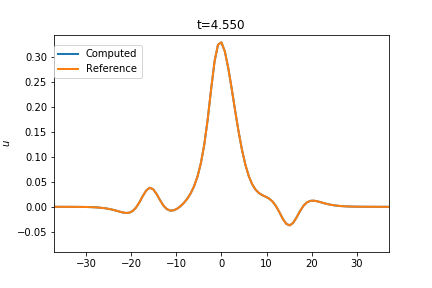
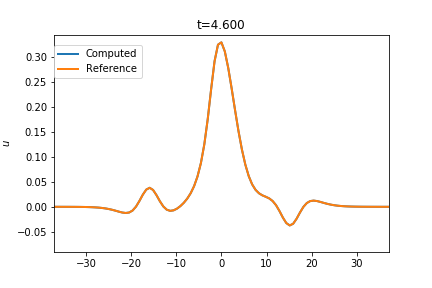
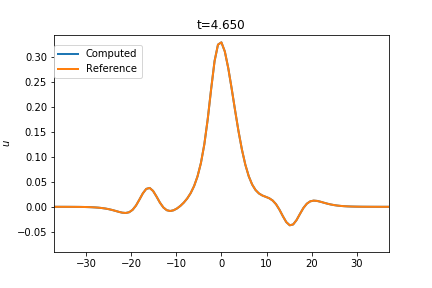
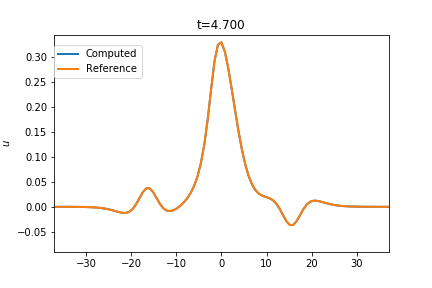
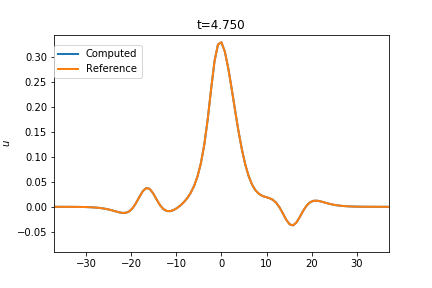
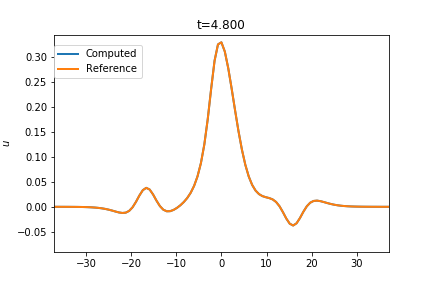
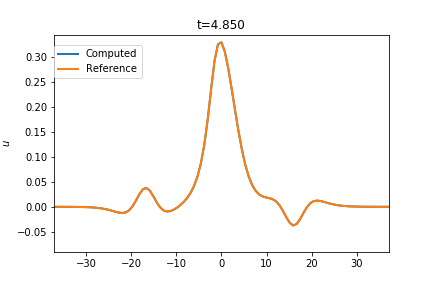
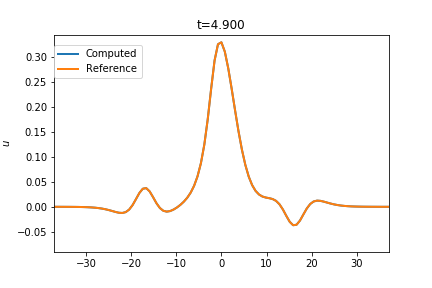
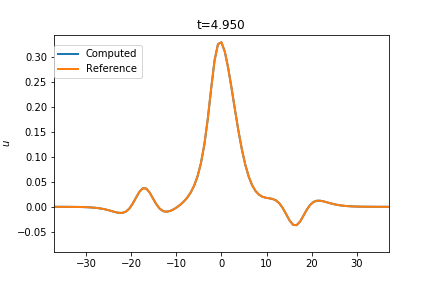
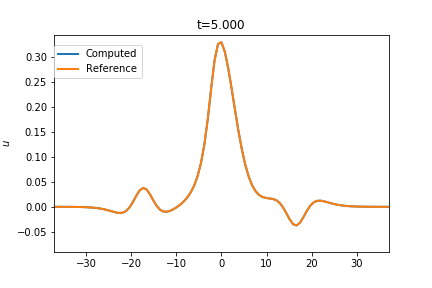
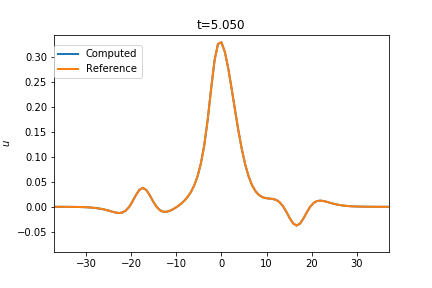
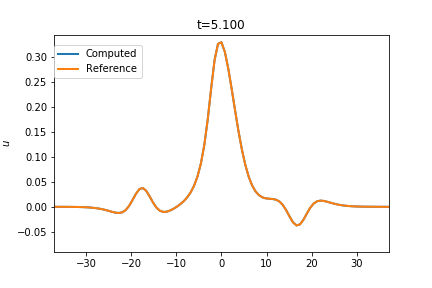
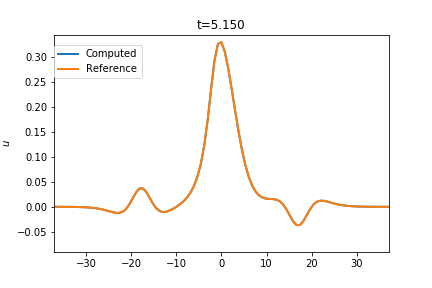
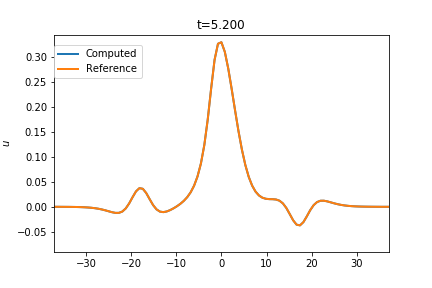
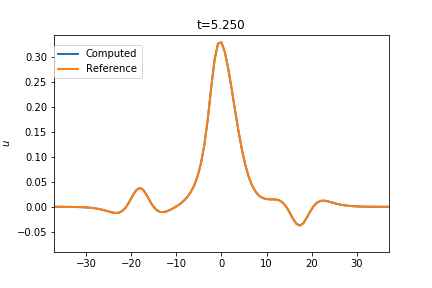
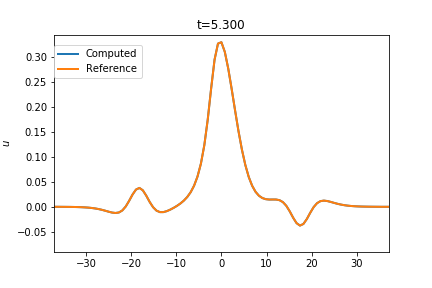
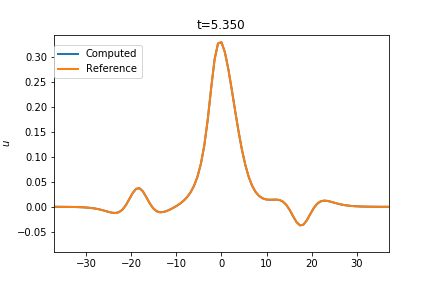
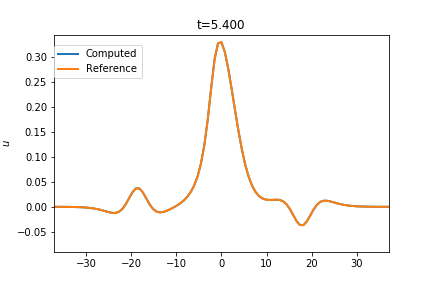
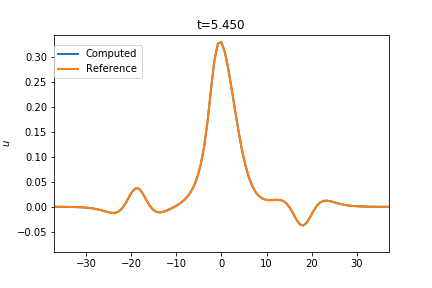
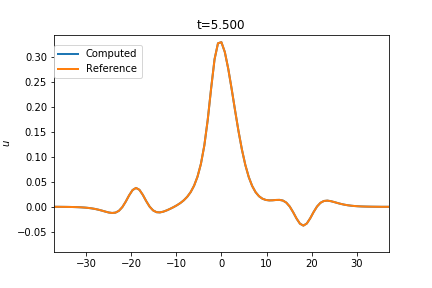
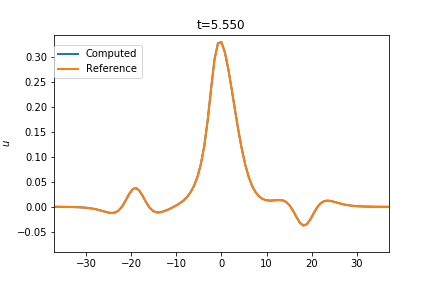
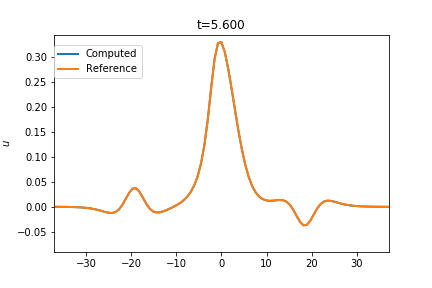
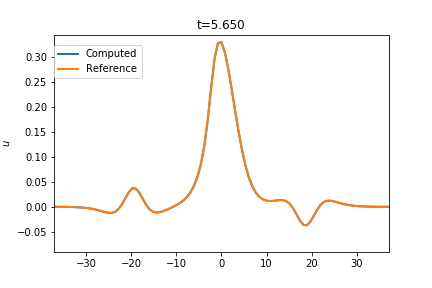
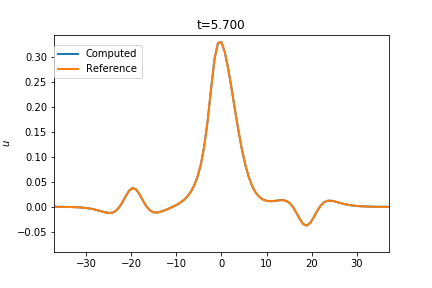
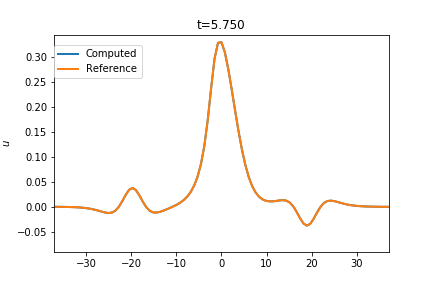
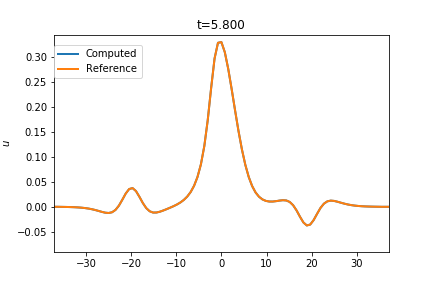
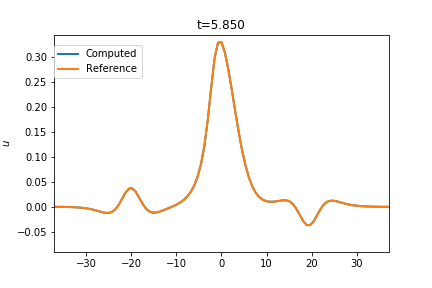
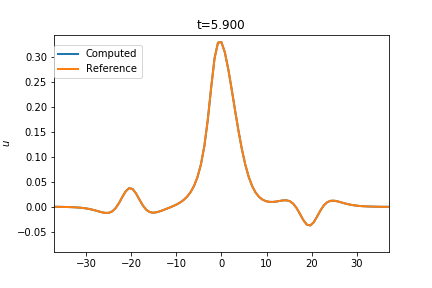
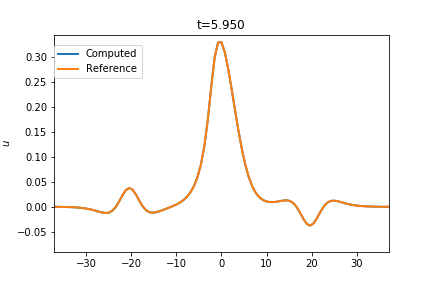
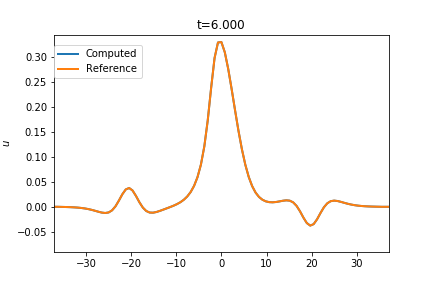
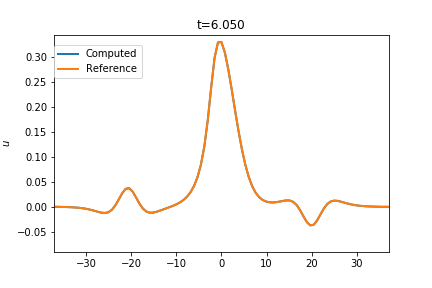
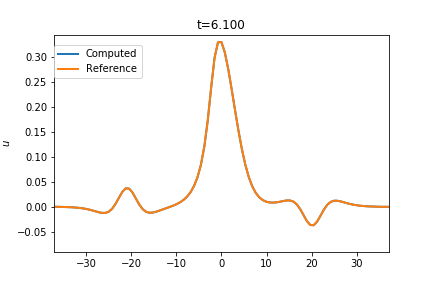
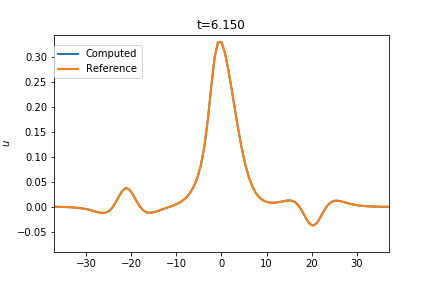
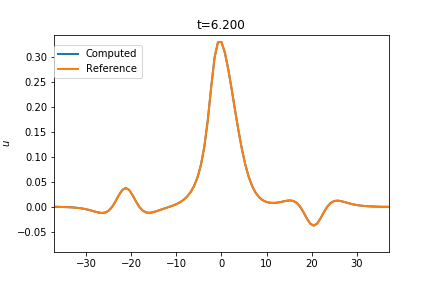
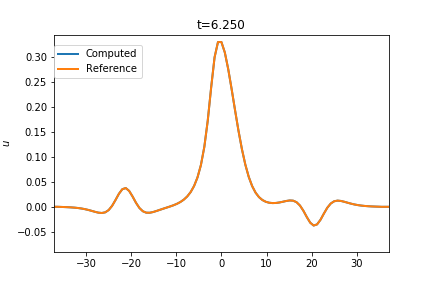
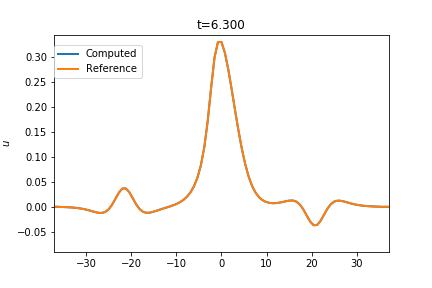
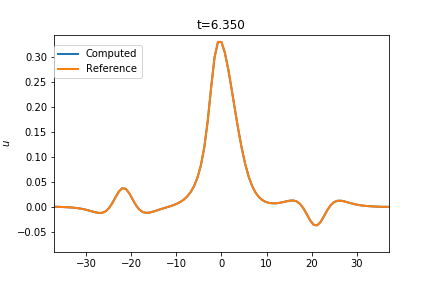
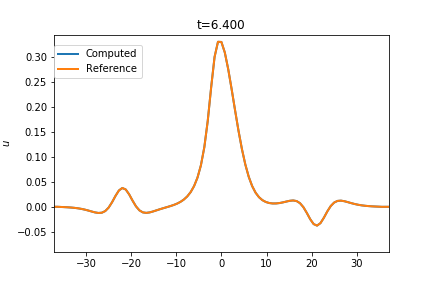
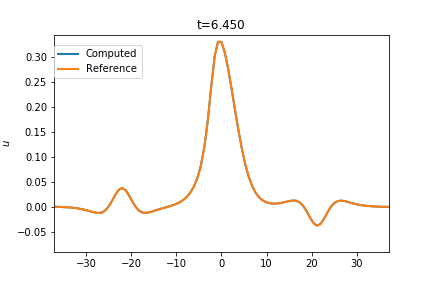
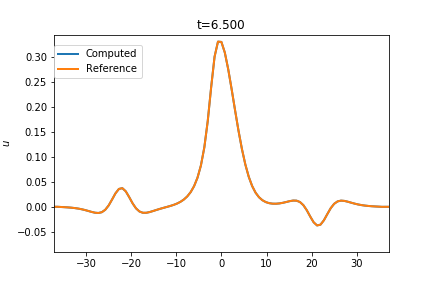
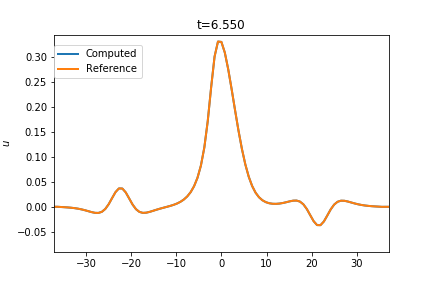
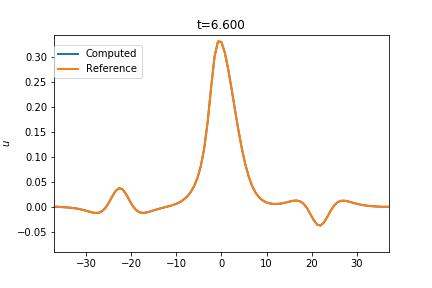
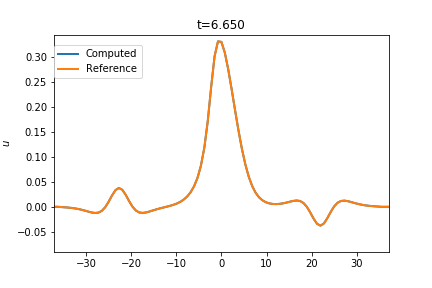
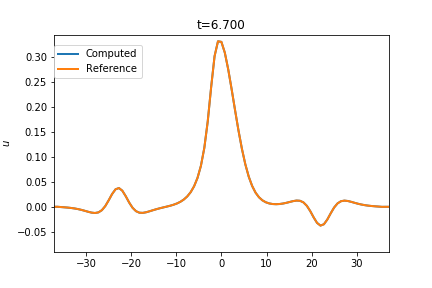
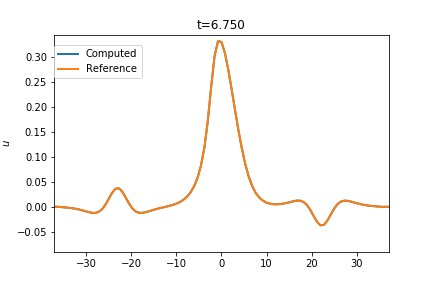
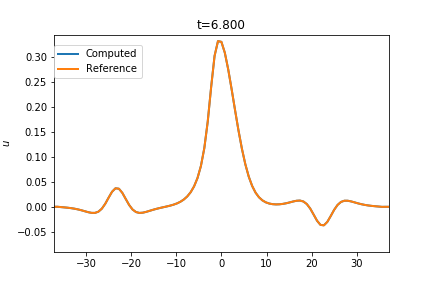
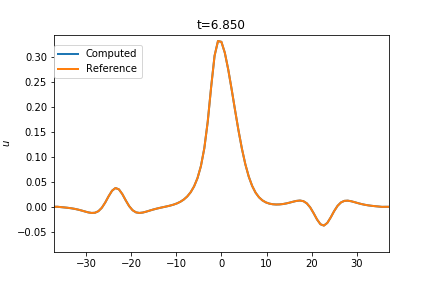
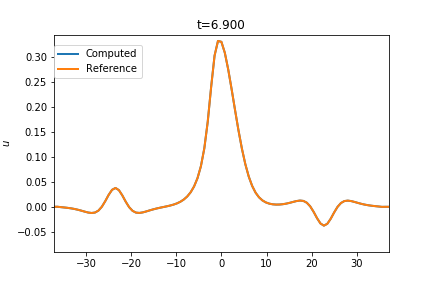
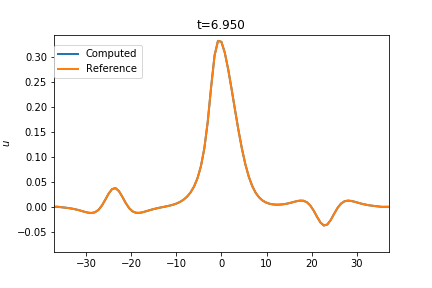
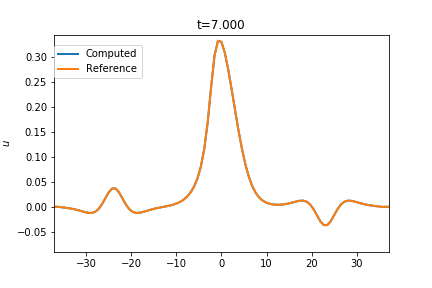
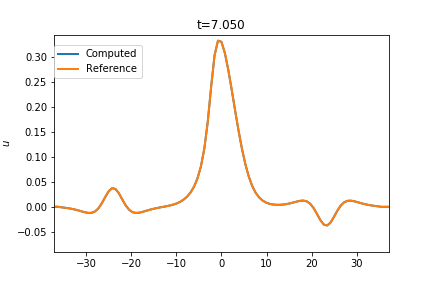
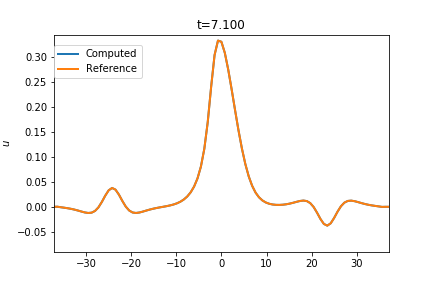
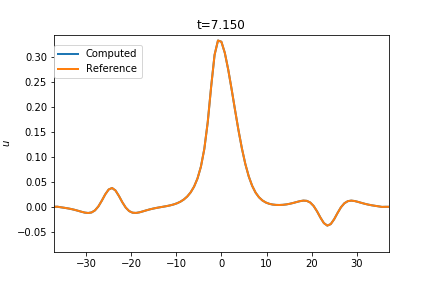
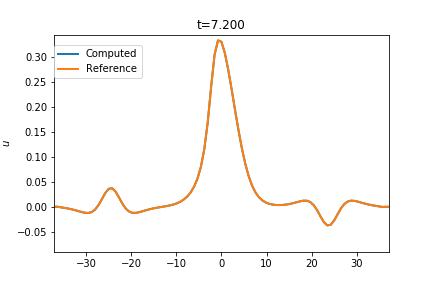
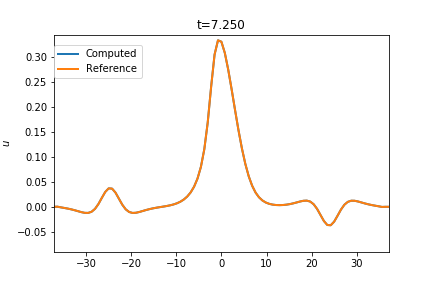
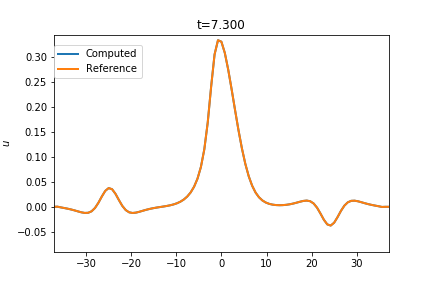
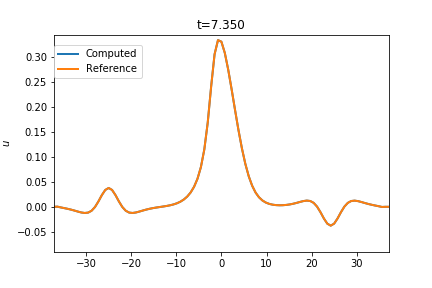
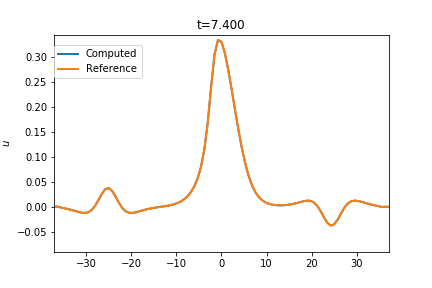
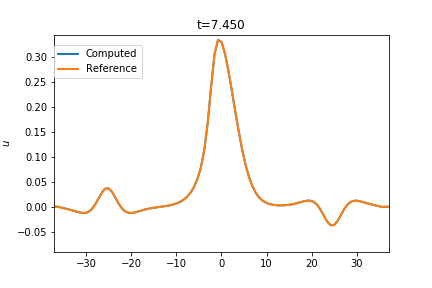
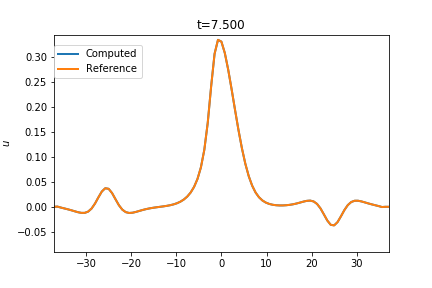
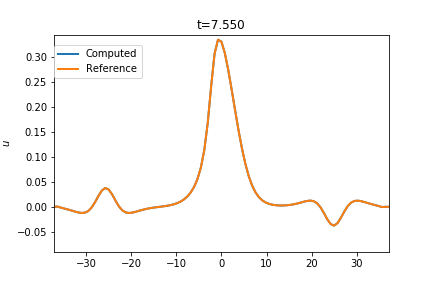
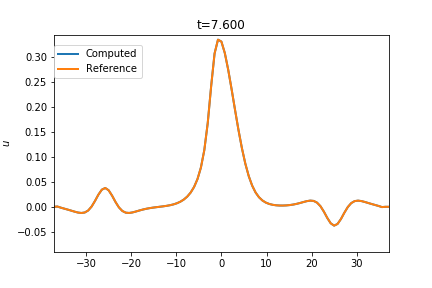
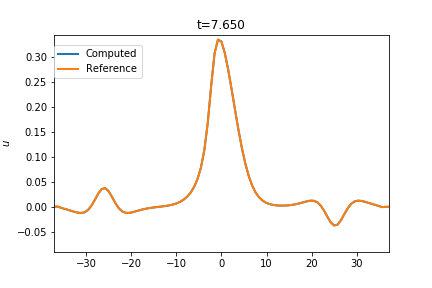
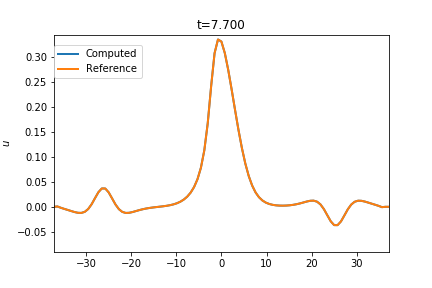
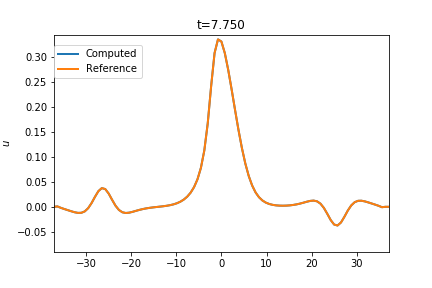
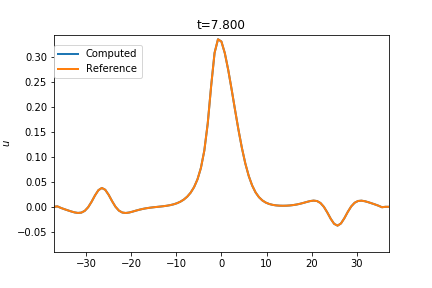
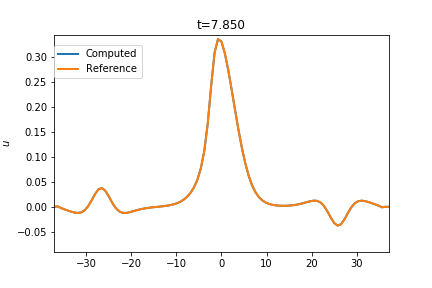
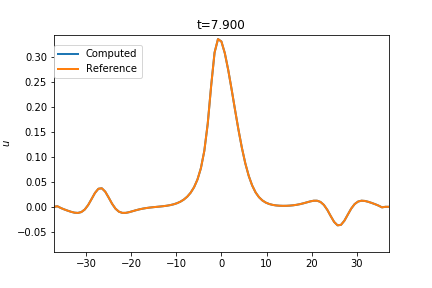
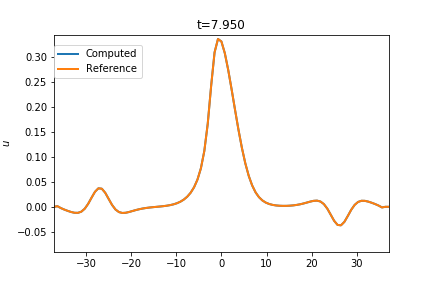
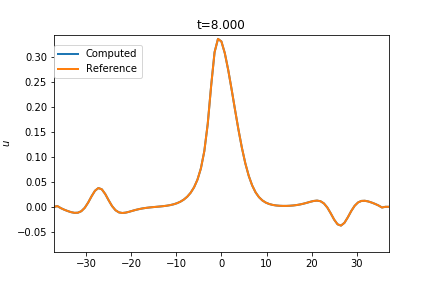
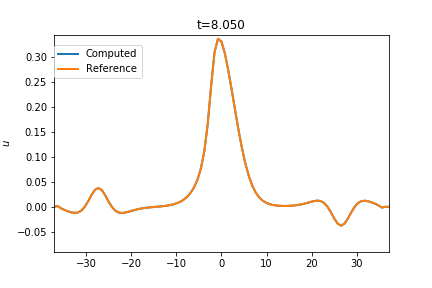
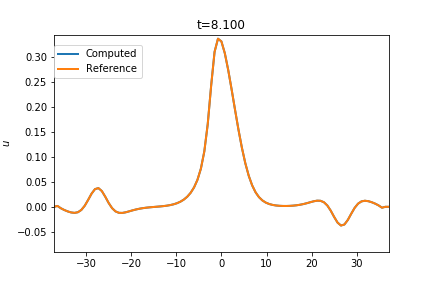
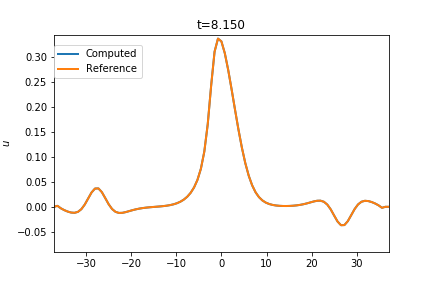
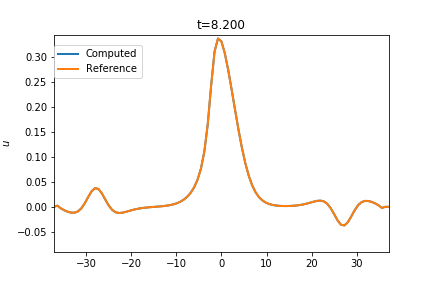
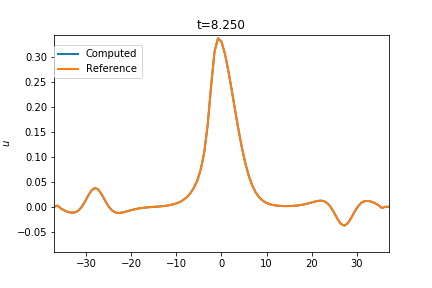
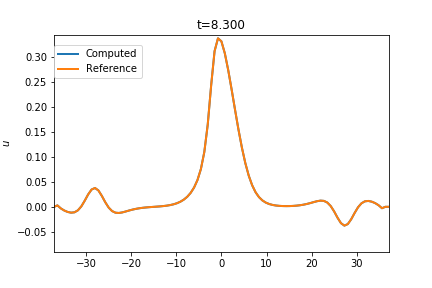
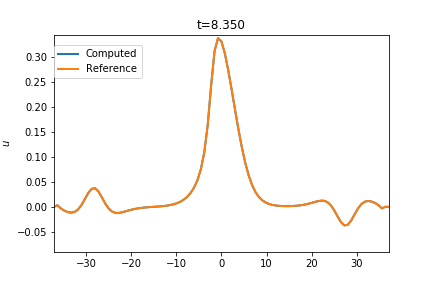
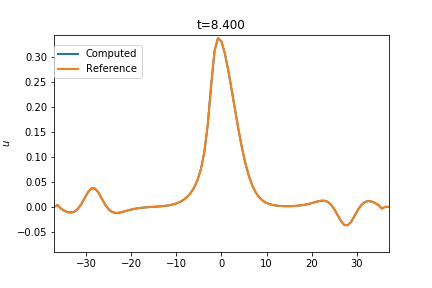
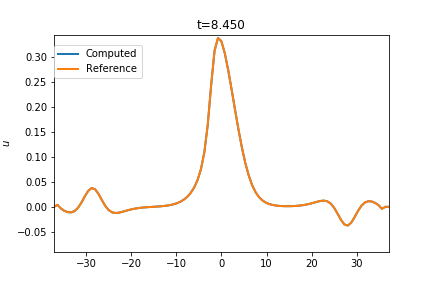
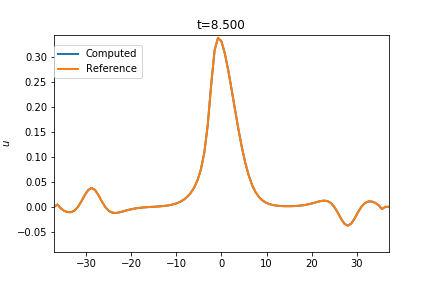
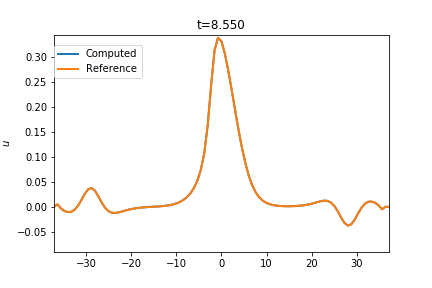
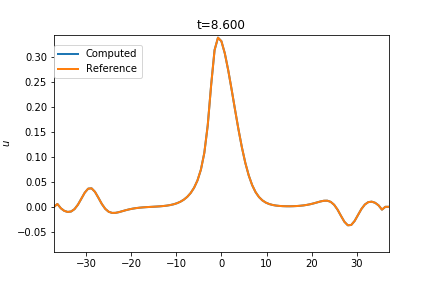
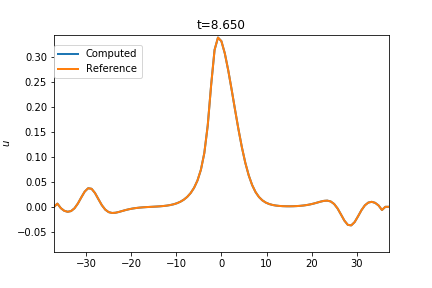
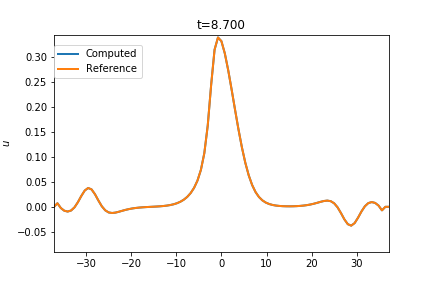
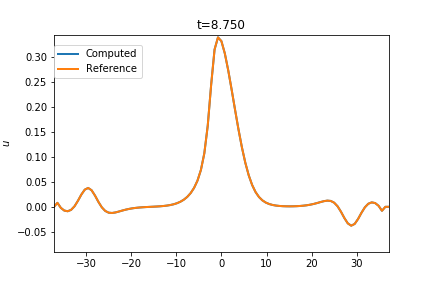
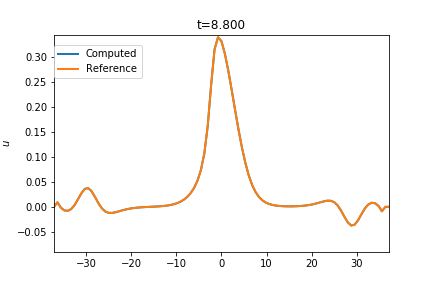
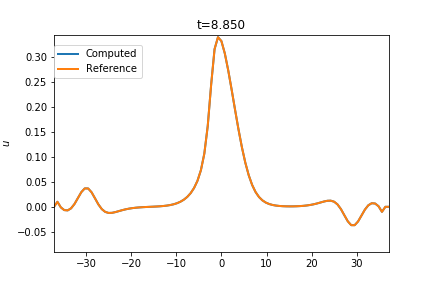
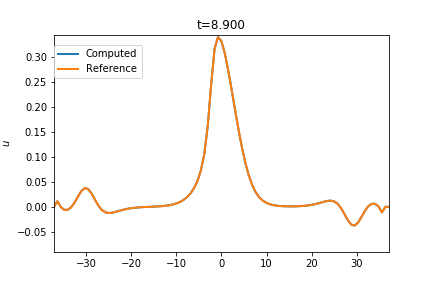
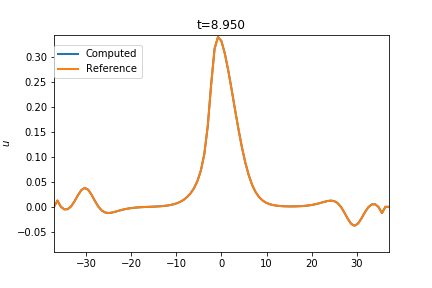
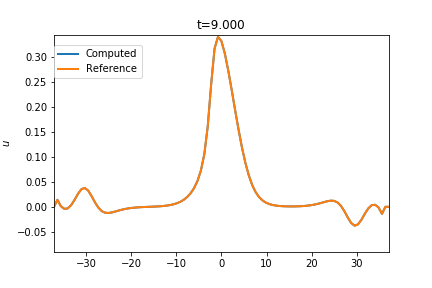
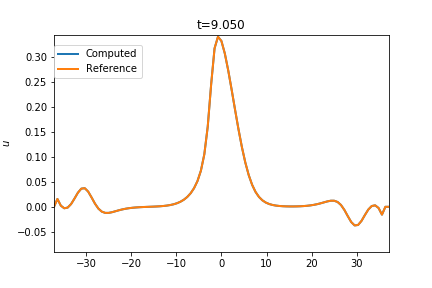
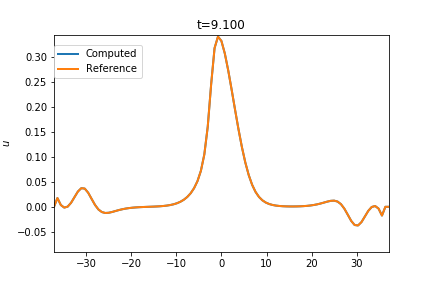
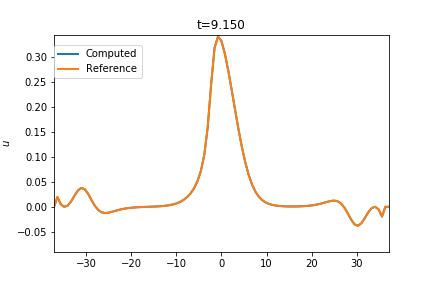
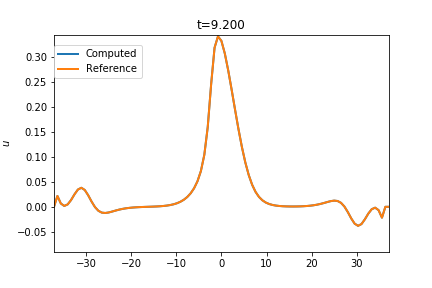
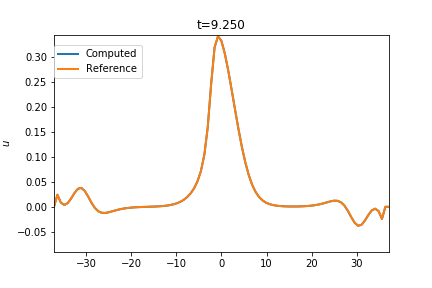
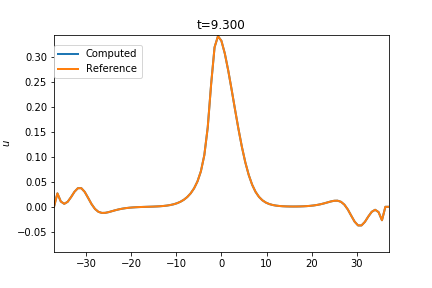
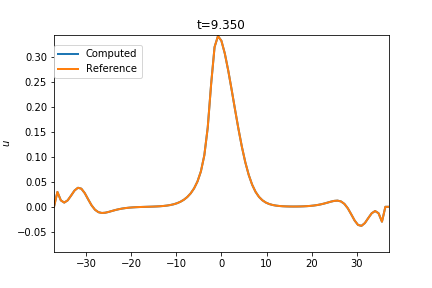
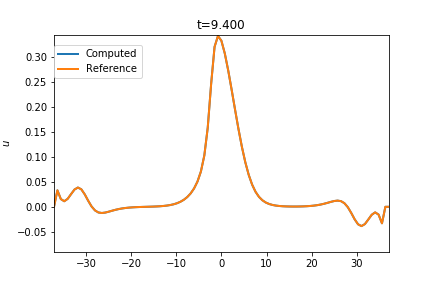
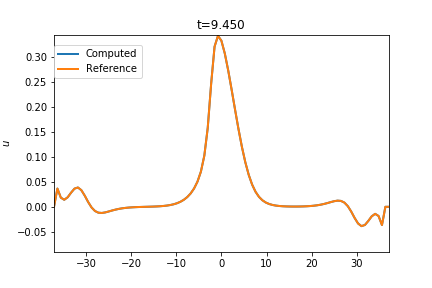
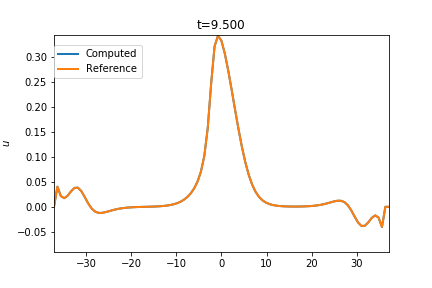
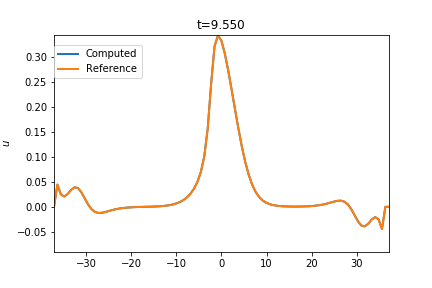
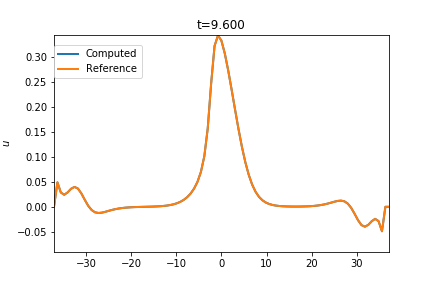
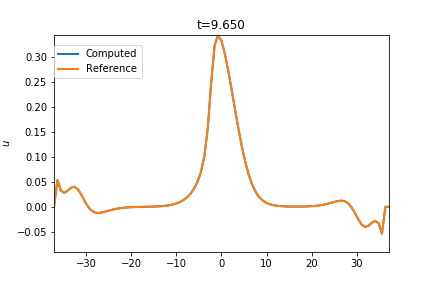
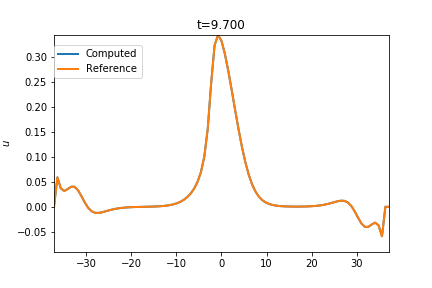
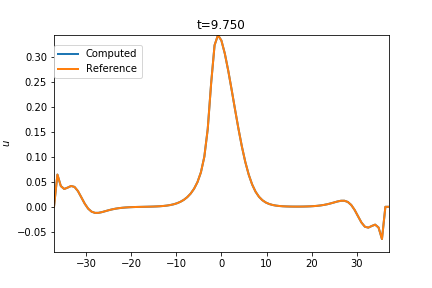
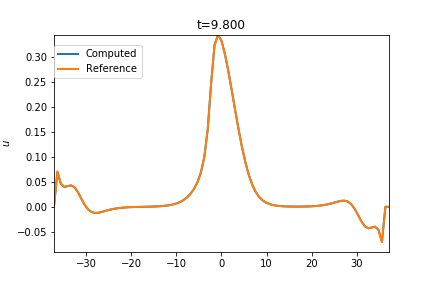
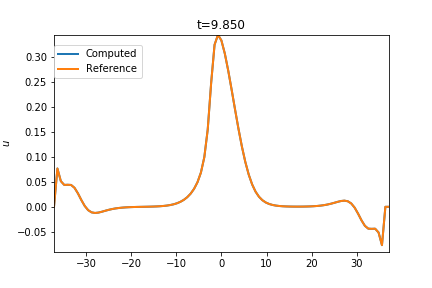
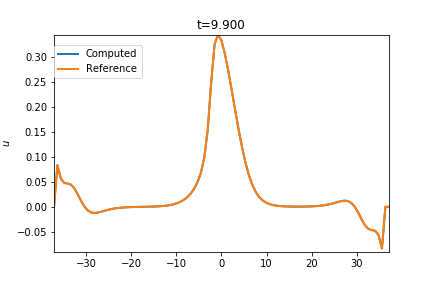
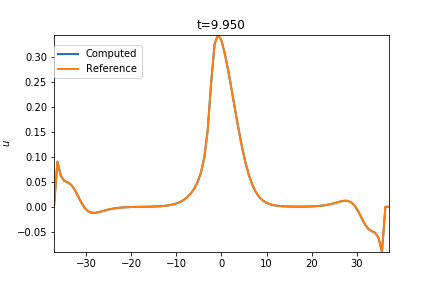

In [12]:
lb = ["Computed","Reference"]
gF.plotAnimationNSolutions(2,x,np.array([uall,uallref]),tall,xmin+dx,xmax-dx,umin,umax,lb,ylabel=r'$u$',location=(0.,0.8))